In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
import warnings
import datetime
import pandas_datareader as pdr
from sklearn.covariance import LedoitWolf
warnings.filterwarnings("ignore")
from scipy.stats import ttest_ind
from collections import defaultdict


## Data preparation

This section loads and aligns all necessary inputs:
- Daily returns and polarity scores from sentiment data
- Risk-free rate from FRED
- Market values to compute a benchmark portfolio (value-weighted)


In [2]:
# Load the main file
df = pd.read_csv('sentratio_and_price_closetoclose_adj2_v2.csv', index_col='date')
tickers = df['ticker'].unique()
tickers = np.delete(tickers,[-2] ) # Remove Twitter

# Create a Dataframe of returns
df_returns = pd.DataFrame()
for tic in tickers:
    df_returns[tic] = df.loc[df['ticker'] == tic, 'daily_return']
df_returns.dropna(inplace=True)
prev_returns_df = df_returns.shift(1).dropna()

# Create a Dataframe of polarity
df_polarity = pd.DataFrame()
for tic in tickers:
    df_polarity[tic] = df.loc[df['ticker'] == tic, 'Polarity']
    
    
# Convert index to datetime + select common dates between returns & polarity 
df_returns.index = pd.to_datetime(df_returns.index).tz_localize(None)
df_polarity.index = pd.to_datetime(df_polarity.index).tz_localize(None)
common_dates = df_returns.index.intersection(df_polarity.index)
df_returns = df_returns.loc[common_dates]
df_polarity = df_polarity.loc[common_dates]

# Risk-free rate
# Download the data and divers prep as before
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()
rf_data = pdr.get_data_fred('DFF', start, end)
rf_data.index.name = 'date'  # Rename the index to match df_returns
rf_data = rf_data[rf_data.index.isin(common_dates)]
rf_data = rf_data / 100 / 252 # Convert annual rate to daily percent
rf_data.index = pd.to_datetime(rf_data.index).tz_localize(None)


# Market portfolio
# Load + create dataframe for Market values of the tickers
df_mv = pd.read_excel('market_values_tickers.xlsx')
df_mv = df_mv.set_index(df_mv['Date'])
df_mv.drop(columns='Date', inplace=True)
df_mv.dropna(inplace=True)
df_mv.columns = df_returns.columns
df_mv.index.name = 'date' 
df_mv = df_mv.loc[common_dates]
df_mv = df_mv.transpose()

# Compute the weights to build the market portfolio
total_monthly_value = df_mv.sum(axis=0)
vw_monthly_weights = pd.DataFrame()
for column in df_mv.columns:
    vw_monthly_weights[f'{column}'] = df_mv[column] / total_monthly_value[column]
x0_vw = vw_monthly_weights.transpose()
x0_vw.columns = df_polarity.columns
x0_vw = x0_vw.shift(1).dropna() # SHIFT SO X0 IS INDEXED BY THE DAY THE DATA IS USED NOT BASED ON
x0_vw.index = pd.to_datetime(x0_vw.index).tz_localize(None)

## Functions Overview

### 1. Portfolio Construction  
Covariance estimation, implied returns, and optimization objective.

- `variance_covariance_matrix`: Rolling Ledoit-Wolf covariance estimation.  
- `gamma_matrix`: Scales Σ with Black-Litterman τ.  
- `calculate_implied_exp_returns_for_a_time_period`: Generates μ across time.  
- `QP`: Defines the mean-variance optimization problem.

### 2. Signal & View Generation  
Regression analysis, t-stats, omega, and filtered views.

- `reg_var_pol_var_ret_all_tickers`: Rolling regression of return on sentiment.  
- `omega_matrix_1_day`: Constructs the view uncertainty matrix Ω.  
- `compute_views`: Filters and scales views using t-stats and market context.

### 3. Strategy Execution  
Rolling portfolio optimization with or without sentiment views.

- `optimized_weights_full_views_time_period`: View-adjusted daily weights.  
- `weights_ptf_no_views`: Optimization using implied returns only.  
- `weights_ptf_VW`: Passive benchmark weights with volatility targeting.

### 4. Performance Evaluation  
Metrics for assessing portfolio performance.

- `ptf_daily_return`: Net returns including transaction costs.  
- `cumulative_return`, `total_return`, `annual_return`  
- `annual_volatility`, `annual_sharpe_ratio`  
- `max_drawdown`, `drawdown_over_time`, `ptf_metrics`

### 5. Legacy Methods & Reference Functions



In [3]:
# --- 1. Portfolio Construction ---



def variance_covariance_matrix(start_date, end_date, returns, window_size,win_size_VT):
     
    """
    Computes a rolling window covariance matrix using the Ledoit-Wolf shrinkage estimator.

    Parameters:
    - start_date (str or Timestamp): Start date of the evaluation period.
    - end_date (str or Timestamp): End date of the evaluation period.
    - returns (pd.DataFrame): Asset returns with datetime index.
    - window_size (int): Size of the rolling window for estimation.
    - win_size_VT (int): Additional buffer for volatility targeting or look-back calculations.Used to ensure sufficient historical
    data is available **before** the start date for rolling statistics such as volatility.

    Returns:
    - dict: Dictionary of covariance matrices indexed by usage date (next day after each window).
    """
    
    # Ensure datetime format
    returns.index = pd.to_datetime(returns.index)

    # Get index positions
    start_idx = returns.index.get_loc(start_date)
    end_idx = returns.index.get_loc(end_date)
    buffer_idx = start_idx - window_size - win_size_VT

    # Restrict to data covering full buffer + evaluation range
    returns_filtered = returns[buffer_idx:end_idx + 1]

    # Initialize Ledoit-Wolf estimator and result dictionary
    lw = LedoitWolf()
    vcv_dict = {}

    # Rolling window estimation loop
    for i in range(len(returns_filtered) - window_size):
        window_data = returns_filtered[i:i + window_size]
        lw.fit(window_data)
        cov_matrix = pd.DataFrame(
            lw.covariance_,
            index=window_data.columns,
            columns=window_data.columns
        )

        # Map to the next day (evaluation/usage date)
        try:
            eval_date = returns_filtered.index[i + window_size]
            vcv_dict[eval_date] = cov_matrix
        except IndexError:
            break  # Final window — skip incomplete range

    return vcv_dict


def gamma_matrix(tau,var_cov_matrix):
    
    """
    Scales the variance-covariance matrix using the Black-Litterman τ parameter.

    Parameters:
    - tau (float): Scalar representing uncertainty in the prior.
    - var_cov_matrix (ndarray or DataFrame): Covariance matrix of asset returns.

    Returns:
    - ndarray: Scaled covariance matrix (tau * Σ).
    """
    
    gamma_matrix = tau * var_cov_matrix
    
    return gamma_matrix


def calculate_implied_exp_return(vcv, x0, rf, risk_aversion):
    
    """
    Computes the Black-Litterman implied expected return (μ) for 1 day.

    Parameters:
    - vcv (DataFrame): Covariance matrix of asset returns.
    - x0 (Series): Prior (market or benchmark) weights.
    - rf (float or array): Risk-free rate.
    - risk_aversion (float): Risk aversion coefficient (λ).

    Returns:
    - DataFrame: Transposed 1-row DataFrame with μ vector.
    
    """
    
    # Ensure rf is scalar array (1D)
    rf_array = np.array(rf).squeeze()

    # Construct vector of risk-free returns (r)
    r_vector = rf_array * np.ones(len(vcv))

    # Compute implied expected returns: μ = r + λ * Σ @ w
    mu_vector = r_vector + risk_aversion * vcv @ x0

    # Format result as a 1-row DataFrame indexed by date
    mu = pd.Series(mu_vector, index=x0.index).to_frame().T
    mu.index = [x0.name]

    return mu


def calculate_implied_exp_returns_for_a_time_period(
    dict_of_vcv,
    x0_series,
    rf_series,
    risk_aversion,
    start_date,
    end_date,
    win_size_VT
):
    """
    Computes a time series of implied expected returns (μ) using the Black-Litterman model
    across a rolling time period.

    Parameters
    ----------
    dict_of_vcv : dict of pd.DataFrame
        Dictionary mapping dates to covariance matrices (Σ).
    x0_series : pd.DataFrame
        DataFrame of prior weights (e.g., market-cap), indexed by date.
    rf_series : pd.Series or pd.DataFrame
        Time series of risk-free rates, indexed by date.
    risk_aversion : float
        Risk aversion coefficient (λ).
    start_date : str or pd.Timestamp
        Start of evaluation window.
    end_date : str or pd.Timestamp
        End of evaluation window.
    win_size_VT : int
        Volatility-targeting buffer (lookback window).Used to ensure sufficient historical
    data is available **before** the start date for rolling statistics such as volatility.

    Returns
    -------
    pd.DataFrame
        Time-indexed DataFrame of implied expected returns for each asset.
    """

    implied_exp_return_rows = []

    # Ensure datetime index
    x0_series.index = pd.to_datetime(x0_series.index)
    rf_series.index = pd.to_datetime(rf_series.index)

    # Calculate index bounds / Subtract win_size_VT to ensure data buffer for volatility targeting computation
    start_idx_x0 = x0_series.index.get_loc(start_date) - win_size_VT
    end_idx_x0 = x0_series.index.get_loc(end_date)
    start_idx_rf = rf_series.index.get_loc(start_date) - win_size_VT
    end_idx_rf = rf_series.index.get_loc(end_date)

    # Select relevant data ranges
    x0_filtered = x0_series[start_idx_x0:end_idx_x0 + 1].dropna() # No shift because x0 already at usage date
    rf_filtered = rf_series[start_idx_rf - 1:end_idx_rf + 1].shift(1).dropna() # Shift to avoid look-ahead bias

    # Loop over valid dates to compute expected return
    for date in rf_filtered.index:
        implied_exp_return_rows.append(
            calculate_implied_exp_return(
                dict_of_vcv[pd.Timestamp(date)],
                x0_filtered.loc[pd.Timestamp(date)],
                rf_filtered.loc[pd.Timestamp(date)],
                risk_aversion
            )
        )

    # Concatenate into final DataFrame
    implied_exp_returns = pd.concat(implied_exp_return_rows)

    return implied_exp_returns


def QP(x, sigma, mu, risk_aversion,x_prev,turnover_penalty):
    
    """
    Objective function for quadratic optimization with turnover penalty.

    Parameters:
    - x (array): Candidate portfolio weights.
    - sigma (ndarray): Covariance matrix of returns.
    - mu (ndarray): Expected returns.
    - risk_aversion (float): Risk aversion coefficient.
    - x_prev (array): Previous day's weights (for turnover penalty).
    - turnover_penalty (float): Cost associated with weight changes.

    Returns:
    - float: Value of the objective function.
    """
    
    gamma = 1 / risk_aversion     # Risk tolerance
    turnover_cost = np.sum(np.abs(x - x_prev))

    objective = (
        0.5 * x.T @ sigma @ x           # Risk term
        - gamma * x.T @ mu              # Expected return term
        + turnover_penalty * turnover_cost  # Turnover penalty
    )

    return objective



# --- 2. Signal & View Generation ---



def reg_var_pol_var_ret_1_asset(polarity, returns, start_date, end_date, window_size, ticker, win_size_VT):
    """
    Rolling regression of daily return variation on lagged polarity variation (1 asset).

    Parameters:
    - polarity (Series): Daily sentiment signal.
    - returns (Series): Daily asset returns.
    - start_date, end_date: Evaluation period.
    - window_size (int): Lookback for rolling regression.
    - ticker (str): Ticker name (used in columns).
    - win_size_VT (int): Volatility-targeting buffer.

    Returns:
    - beta_pivot (DataFrame): Rolling beta values.
    - tval_pivot (DataFrame): T-statistics of beta.
    - residual_var_pivot (DataFrame): Residual variances.
    """

    # Ensure datetime format
    returns.index = pd.to_datetime(returns.index)
    polarity.index = pd.to_datetime(polarity.index)

    # Define raw index bounds (not shifted yet)
    start_raw = returns.index.get_loc(start_date)
    end_raw = returns.index.get_loc(end_date)

    # Compute aligned variations
    returns_var = returns[start_raw - window_size - win_size_VT + 1 : end_raw + 1].diff().dropna()
    polarity_var = polarity[start_raw - window_size - win_size_VT : end_raw + 1].diff().shift(1).dropna()

    # Recalculate start index on filtered data
    start_filtered = returns_var.index.get_loc(start_date) - win_size_VT

    # Results containers
    beta_results, tval_results, resid_results = [], [], []

    for i in range(len(returns_var) - window_size + 2):
        y = returns_var[i : i + start_filtered]
        X = sm.add_constant(polarity_var[i : i + start_filtered])
        model = sm.OLS(y, X).fit()

        date = returns.index[start_raw - win_size_VT + i]

        beta_results.append({"Date": date, "Ticker": ticker, "Beta": model.params[1]})
        tval_results.append({"Date": date, "Ticker": ticker, "T-Value": model.tvalues[1]})
        resid_results.append({"Date": date, "Ticker": ticker, "Residual_Var": np.var(model.resid)})

    # Pivot to get final DataFrames
    beta_df = pd.DataFrame(beta_results).pivot(index="Date", columns="Ticker", values="Beta")
    tval_df = pd.DataFrame(tval_results).pivot(index="Date", columns="Ticker", values="T-Value")
    resid_df = pd.DataFrame(resid_results).pivot(index="Date", columns="Ticker", values="Residual_Var")

    return beta_df, tval_df, resid_df


def reg_var_pol_var_ret_all_tickers(polarity_df, returns_df, start_date, end_date, window_size, tickers, win_size_VT):
    """
    Runs rolling polarity-return regression for all tickers.

    Returns:
    - beta_result, tval_result, resid_result: DataFrames indexed by date, with tickers as columns.
    """
    beta_all, tval_all, resid_all = [], [], []

    for ticker in tickers:
        beta, tval, resid = reg_var_pol_var_ret_1_asset(
            polarity_df[ticker],
            returns_df[ticker],
            start_date,
            end_date,
            window_size,
            ticker,
            win_size_VT
        )
        beta_all.append(beta)
        tval_all.append(tval)
        resid_all.append(resid)

    return pd.concat(beta_all, axis=1), pd.concat(tval_all, axis=1), pd.concat(resid_all, axis=1)


def omega_matrix_1_day(t_values,tickers,residual_var,epsilon=1e-6):
    
    """
    Constructs the Omega matrix (uncertainty in views) for a single day using t-values and residual variances.

    Parameters:
    - t_values (array): t-statistics from signal regressions for each asset.
    - tickers (list): List of asset tickers.
    - residual_var (array): Residual variances from regressions.
    - epsilon (float): Small constant to avoid division by zero.

    Returns:
    - ndarray: Diagonal Omega matrix for Black-Litterman.
    """
    omega_matrix = np.eye(len(tickers))

    for idx in range(len(tickers)):
        t = np.abs(t_values[idx])
        res_var = residual_var[idx]

        if t <= 2 or t == 0 or np.isnan(t) or np.isnan(res_var):
            # Weak signal: assign high uncertainty
            omega_matrix[idx, idx] = 1e20
        else:
            # Confidence inversely proportional to squared t-stat
            omega_matrix[idx, idx] = res_var / ((t / 1)**2 + epsilon)

    return omega_matrix


def market_rolling_volatility(returns, x0, start_date, end_date, win_size_VT, win_rol):
    """
    Computes market portfolio rolling volatility using benchmark weights.

    Parameters:
    - returns (DataFrame): Asset returns.
    - x0 (DataFrame): Benchmark weights.
    - start_date, end_date (str): Evaluation range.
    - win_size_VT (int): Buffer for return volatility.
    - win_rol (int): Rolling window size.

    Returns:
    - Series: Market volatility over time (shifted by 1 to avoid look-ahead bias).
    """
    start_ret = returns.index.get_loc(start_date) - win_rol - win_size_VT
    end_ret = returns.index.get_loc(end_date)

    start_x0 = x0.index.get_loc(start_date) - win_rol - win_size_VT
    end_x0 = x0.index.get_loc(end_date)

    ret_subset = returns.iloc[start_ret:end_ret+1]
    x0_subset = x0.iloc[start_x0:end_x0+1]

    market_ret = (ret_subset * x0_subset).sum(axis=1)
    return market_ret.rolling(win_rol).std().shift().dropna()

    
def adaptive_quantile(rolling_vol, low_vol=0.01, high_vol=0.03, min_q=0.5, max_q=0.9):
    """
    Dynamically adjusts the quantile threshold based on market volatility.

    Higher market volatility lowers the quantile threshold, making it easier for signals to qualify.
    Lower volatility raises the threshold, demanding stronger signals.

    Parameters:
    - rolling_vol (Series): Rolling market volatility.
    - low_vol (float): Lower bound for volatility normalization.
    - high_vol (float): Upper bound for volatility normalization.
    - min_q (float): Minimum quantile threshold (used in high-vol environments).
    - max_q (float): Maximum quantile threshold (used in low-vol environments).

    Returns:
    - Series: Adjusted quantile thresholds over time.
    """
    scaled = (rolling_vol - low_vol) / (high_vol - low_vol)
    scaled = scaled.clip(0, 1)
    return (max_q - (max_q - min_q) * scaled).fillna((min_q + max_q) / 2)


def compute_quantile(returns, quantile_df, win_size_quant):
    """
    Computes rolling quantile cutoffs of absolute returns using a dynamic threshold.

    For each date, it calculates the given quantile of absolute returns over a fixed rolling window.
    This is used to detect high-activity return days relative to historical distribution.

    Parameters:
    - returns (DataFrame): Daily asset returns.
    - quantile_df (Series): Date-indexed quantile thresholds (adjusted from market volatility).
    - win_size_quant (int): Lookback window to compute rolling quantiles.

    Returns:
    - DataFrame: Rolling quantile cutoff values for each asset and date.
    """
    quant_values = {}

    for date in quantile_df.index:
        end_idx = returns.index.get_loc(date)
        start_idx = end_idx - win_size_quant
        window_data = returns.iloc[start_idx:end_idx].abs()
        quant_values[date] = window_data.quantile(quantile_df[date])

    return pd.DataFrame(quant_values).T


def compute_views(implied_exp_ret, polarity, start_date, end_date, betas, t_stat,
                  win_size_VT, steepness, midpoint, returns, window_size):
    """
    Builds the Black-Litterman view matrix Q using polarity shocks and conditional filtering.

    For each asset and day, this function adjusts the implied expected return with a sentiment-based
    signal, scaled by a gamma factor that reflects both:
      - The strength of the regression t-statistics (signal confidence).
      - The magnitude of recent returns relative to an adaptive quantile threshold (market activity).

    Gamma is computed with a sigmoid function to softly scale views instead of hard thresholds.

    Parameters:
    - implied_exp_ret (DataFrame): Implied expected returns (mu).
    - polarity (DataFrame): Daily polarity signal per asset.
    - start_date (str or Timestamp): Start of evaluation window.
    - end_date (str or Timestamp): End of evaluation window.
    - betas (DataFrame): Regression betas (impact of sentiment on return).
    - t_stat (DataFrame): Corresponding t-statistics for each beta.
    - win_size_VT (int): Volatility targeting window (lookback buffer).
    - steepness (float): Steepness of the sigmoid function.
    - midpoint (float): Midpoint of sigmoid.
    - returns (DataFrame): Daily asset returns.
    - window_size (int): Window size for computing quantiles.

    Returns:
    - DataFrame: View matrix Q for use in posterior return computation.
    """

    # Compute variations
    polarity_var = polarity.diff()
    ret_shift = returns.abs().shift(1)

    # Compute rolling return quantile threshold
    market_vol = market_rolling_volatility(
        returns, x0_vw, start_date, end_date, win_size_VT, win_rol=win_size_VT
    )
    quantiles_threshold = adaptive_quantile(
        market_vol, low_vol=0.01, high_vol=0.02, min_q=0.5, max_q=0.95
    )
    quantile_values = compute_quantile(returns, quantiles_threshold, window_size)

    # Get index ranges
    start_idx_mu = implied_exp_ret.index.get_loc(start_date) - win_size_VT
    end_idx_mu = implied_exp_ret.index.get_loc(end_date)
    start_idx_b = betas.index.get_loc(start_date) - win_size_VT
    end_idx_b = betas.index.get_loc(end_date)
    start_idx_pol = polarity_var.index.get_loc(start_date) - win_size_VT
    end_idx_pol = polarity_var.index.get_loc(end_date)
    start_idx_ret = ret_shift.index.get_loc(start_date) - win_size_VT
    end_idx_ret = ret_shift.index.get_loc(end_date)

    # Slice filtered views input
    mu_slice = implied_exp_ret.iloc[start_idx_mu:end_idx_mu + 1]
    beta_slice = betas.iloc[start_idx_b:end_idx_b + 1]
    tval_slice = t_stat.iloc[start_idx_b:end_idx_b + 1]
    polarity_slice = polarity_var.iloc[start_idx_pol - 1:end_idx_pol + 1].shift(1).dropna()
    ret_slice = ret_shift.iloc[start_idx_ret:end_idx_ret + 1]

    # Construct masks
    mask_signal = (np.abs(tval_slice) > 2) # Only keep views with t stat > 2
    mask_ret = ret_slice > quantile_values.loc[ret_slice.index, ret_slice.columns] # Only keep views if previous absolute return > quantile threshold
    mask = mask_signal & mask_ret

    # Compute gamma (scaled t-stat)
    gamma = 1 / (1 + np.exp(-steepness * (np.abs(tval_slice) - midpoint)))
    gamma = gamma * mask.astype(float)

    # Compute views
    matrix_Q = mu_slice + gamma * (polarity_slice * beta_slice)

    return matrix_Q


    
# --- 3. Strategy Execution ---


    
def optimized_weights_full_views_1_day(
    Q_1d,
    t_values,
    tau,
    var_cov_matrix,
    implied_exp_ret,
    constraints,
    x,
    risk_aversion,
    tickers,
    residual_var,
    x_prev,
    turnover_penalty
):
    """
    Computes optimal portfolio weights for a single day using the Black-Litterman model with full views.

    This function incorporates both implied and subjective views (Q) and adjusts for view confidence 
    via the Omega matrix. It also penalizes turnover to promote realistic weight transitions.

    Parameters
    ----------
    Q_1d : pd.Series
        View vector (Q) for the current day.
    t_values : array-like
        t-statistics used to scale the Omega matrix (view uncertainty).
    tau : float
        Scalar for uncertainty in the prior (used in Black-Litterman adjustment).
    var_cov_matrix : pd.DataFrame or ndarray
        Prior covariance matrix of asset returns (Σ).
    implied_exp_ret : pd.Series
        Implied expected return vector (μ).
    constraints : dict or list of dicts
        Constraints to apply during optimization (e.g., bounds, weights sum to 1).
    x : array-like
        Initial guess for optimization.
    risk_aversion : float
        Risk aversion parameter (λ).
    tickers : list
        List of asset tickers (used to define size of identity matrix).
    residual_var : array-like
        Residual variances for each view (used in Omega).
    x_prev : array-like
        Previous day’s weights, for turnover penalty.
    turnover_penalty : float
        Penalization strength for excessive rebalancing.

    Returns
    -------
    optimized_weights : ndarray
        Optimal portfolio weights for the current day.
    """

    # Build view matrix P (identity since views are directly on assets)
    P = np.eye(len(tickers))

    # Construct Omega: diagonal matrix of view uncertainty
    omega_matrix = omega_matrix_1_day(t_values, tickers, residual_var, epsilon=1e-6)

    # Reshape Q and μ into column vectors
    implied_mu = implied_exp_ret.values.reshape(-1, 1)
    Q = Q_1d.values.reshape(-1, 1)

    # Compute posterior expected return (μ̄) using Black-Litterman formula
    tau_sigma = gamma_matrix(tau, var_cov_matrix)
    inv_term = np.linalg.inv(P @ tau_sigma @ P.T + omega_matrix)
    mu_bar = implied_mu + (tau_sigma @ P.T) @ inv_term @ (Q - P @ implied_mu)

    # Solve mean-variance optimization with turnover penalty
    res = minimize(
        QP,
        x,
        args=(var_cov_matrix, mu_bar, risk_aversion, x_prev, turnover_penalty),
        options={'disp': False},
        constraints=constraints
    )

    return res.x


def optimized_weights_full_views_time_period(
    Q,
    t_values,
    tau,
    vcv_dict,
    implied_exp_ret,
    constraints,
    x0,
    risk_aversion,
    tickers,
    start_date,
    end_date,
    residual_var,
    win_size_VT,
    returns,
    target_volatility,
    turnover_penalty
):
    """
    Computes optimal Black-Litterman portfolio weights over a time period, including volatility targeting
    and turnover penalization.

    This function loops over each day in the backtest period and solves a constrained optimization 
    problem using both market-implied and subjective views (Q), scaled with an Omega matrix.

    Parameters
    ----------
    Q : pd.DataFrame
        View matrix indexed by date, one row per day.
    t_values : pd.DataFrame
        t-statistics for views, used to scale Omega (uncertainty).
    tau : float
        Scalar parameter for prior uncertainty in the Black-Litterman model.
    vcv_dict : dict
        Dictionary mapping dates to covariance matrices (Σ).
    implied_exp_ret : pd.DataFrame
        Implied expected return matrix, indexed by date.
    constraints : list or dict
        Constraints for optimization (e.g. sum of weights = 1, bounds).
    x0 : pd.DataFrame
        Market-cap or prior weights, indexed by date.
    risk_aversion : float
        Risk aversion parameter (λ).
    tickers : list
        List of asset tickers.
    start_date : str or pd.Timestamp
        Start date for the evaluation period.
    end_date : str or pd.Timestamp
        End date for the evaluation period.
    residual_var : pd.DataFrame
        Residual variances from regression, indexed by date.
    win_size_VT : int
        Lookback window for volatility targeting.
    returns : pd.DataFrame
        Daily asset returns, indexed by date.
    target_volatility : float
        Target annualized portfolio volatility.
    turnover_penalty : float
        Coefficient penalizing large day-to-day changes in weights.

    Returns
    -------
    pd.DataFrame
        Scaled portfolio weights (after volatility targeting), indexed by date.
    """

    # Initialize list to collect daily optimized weights
    opti_weights_rows = []

    # Determine index boundaries for slicing
    start_idx_mu = implied_exp_ret.index.get_loc(start_date) - win_size_VT
    end_idx_mu = implied_exp_ret.index.get_loc(end_date)
    start_idx_x0 = x0.index.get_loc(start_date) - win_size_VT
    end_idx_x0 = x0.index.get_loc(end_date)
    start_idx_ret = returns.index.get_loc(start_date) - win_size_VT
    end_idx_ret = returns.index.get_loc(end_date)

    # Slice data over buffered window
    implied_exp_ret_selected = implied_exp_ret.iloc[start_idx_mu:end_idx_mu + 1]
    x0_selected = x0.iloc[start_idx_x0:end_idx_x0 + 1]
    returns_selected = returns.iloc[start_idx_ret:end_idx_ret + 1]

    # Set initial weights
    init_weight = x0_selected.iloc[0]

    # Rolling optimization loop
    for date in x0_selected.index:
        if date == x0_selected.index[0]:
            x_prev = init_weight
            turn_penalty = 0  # No penalty on first day
            x_init = init_weight
        else:
            x_prev = x0_selected.loc[date]  # Set market weights as starting point for each day
            turn_penalty = turnover_penalty
            x_init = x_prev

        # Solve Black-Litterman optimization with full views
        x_opt = optimized_weights_full_views_1_day(
            Q.loc[date],
            t_values.loc[date],
            tau,
            vcv_dict[pd.Timestamp(date)],
            implied_exp_ret_selected.loc[date],
            constraints,
            x_init,
            risk_aversion,
            tickers,
            residual_var.loc[date],
            x_prev,
            turn_penalty
        )

        opti_weights_rows.append(x_opt)

    # Convert list to DataFrame
    weights_df = pd.DataFrame(opti_weights_rows, index=x0_selected.index, columns=tickers)

    # Compute realized volatility of portfolio
    portfolio_returns = (weights_df * returns_selected).sum(axis=1)
    realized_vol = portfolio_returns.ewm(span=win_size_VT).std()

    # Compute daily target volatility
    target_vol = target_volatility / np.sqrt(252)

    # Compute scaling factor and clip leverage to 1
    scaling_factor = target_vol / realized_vol
    scaling_factor = scaling_factor.clip(upper=1)

    # Apply scaling to weights
    scaled_weights_df = weights_df.mul(scaling_factor, axis=0)[start_date:end_date]

    return scaled_weights_df


def weights_ptf_no_views(
    constraints,
    start_date,
    end_date,
    vcv_dict,
    risk_aversion,
    implied_mu,
    x0,
    returns,
    win_size_VT,
    target_volatility,
    turnover_penalty
):
    """
    Computes optimal portfolio weights using only implied expected returns (μ),
    without incorporating subjective views (i.e., pure mean-variance optimization).
    Applies volatility targeting and turnover penalization.

    Parameters
    ----------
    constraints : list or dict
        Constraints for optimizer (e.g., weights sum to 1, bounds).
    start_date : str or pd.Timestamp
        Start date for backtest.
    end_date : str or pd.Timestamp
        End date for backtest.
    vcv_dict : dict of pd.DataFrame
        Dictionary mapping dates to covariance matrices.
    risk_aversion : float
        Risk aversion coefficient (λ).
    implied_mu : pd.DataFrame
        DataFrame of implied expected returns, indexed by date.
    x0 : pd.DataFrame
        Prior or initial weights (e.g., market-cap), indexed by date.
    returns : pd.DataFrame
        Asset returns, indexed by date.
    win_size_VT : int
        Lookback window for volatility targeting.
    target_volatility : float
        Target annualized volatility.
    turnover_penalty : float
        Penalty coefficient for excessive weight changes.

    Returns
    -------
    pd.DataFrame
        Scaled daily portfolio weights (no views), indexed by date.
    """

    opti_weight_rows = []

    # Get index ranges with buffer
    start_idx_mu = implied_mu.index.get_loc(start_date) - win_size_VT
    end_idx_mu = implied_mu.index.get_loc(end_date)
    start_idx_x0 = x0.index.get_loc(start_date) - win_size_VT
    end_idx_x0 = x0.index.get_loc(end_date)
    start_idx_ret = returns.index.get_loc(start_date) - win_size_VT
    end_idx_ret = returns.index.get_loc(end_date)

    # Slice input data
    implied_mu_selected = implied_mu.iloc[start_idx_mu:end_idx_mu + 1]
    x0_selected = x0.iloc[start_idx_x0:end_idx_x0 + 1]
    returns_selected = returns.iloc[start_idx_ret:end_idx_ret + 1]

    # Initial weight (used on first day)
    init_weight = x0_selected.iloc[0]

    # Rolling optimization loop
    for date in x0_selected.index:
        if date == x0_selected.index[0]:
            x_prev = init_weight
            turn_penalty = 0  # No penalty on first step
            x_init = init_weight
        else:
            x_prev = x0_selected.loc[date]  # Set market weights as starting point for each day
            turn_penalty = turnover_penalty
            x_init = x_prev

        # Solve optimization with implied μ only
        res = minimize(
            QP,
            x_init,
            args=(
                vcv_dict[pd.Timestamp(date)],
                implied_mu_selected.loc[date],
                risk_aversion,
                x_prev,
                turn_penalty
            ),
            options={'disp': False},
            constraints=constraints
        )

        opti_weight_rows.append(res.x)

    # Format results as DataFrame
    opti_weights = np.vstack(opti_weight_rows)
    weights_df = pd.DataFrame(opti_weights, index=x0_selected.index, columns=x0.columns)

    # Portfolio returns and realized volatility
    portfolio_returns = (weights_df * returns_selected).sum(axis=1)
    realized_vol = portfolio_returns.ewm(span=win_size_VT).std()

    # Target daily volatility
    target_vol = target_volatility / np.sqrt(252)
    scaling_factor = target_vol / realized_vol
    scaling_factor = scaling_factor.clip(upper=1)

    # Apply volatility targeting
    scaled_weights_df = weights_df.mul(scaling_factor, axis=0)[start_date:end_date]

    return scaled_weights_df


def weights_ptf_VW(x0, returns, start_date, end_date, win_size_VT, target_volatility):
    """
    Computes volatility-scaled portfolio weights using a value-weighted benchmark strategy.

    If no volatility targeting is desired (target_volatility = ∞), it returns the raw value weights.

    Parameters
    ----------
    x0 : pd.DataFrame
        Value-weighted (benchmark) weights, indexed by date.
    returns : pd.DataFrame
        Daily asset returns, indexed by date.
    start_date : str or pd.Timestamp
        Start of evaluation window.
    end_date : str or pd.Timestamp
        End of evaluation window.
    win_size_VT : int
        Lookback window for volatility estimation.
    target_volatility : float
        Target annualized portfolio volatility (set to np.inf to disable scaling).

    Returns
    -------
    pd.DataFrame
        Daily portfolio weights with optional volatility targeting applied.
    """

    # Skip volatility targeting if requested
    if np.isinf(target_volatility):
        return x0[start_date:end_date]

    # Define index bounds with volatility buffer
    start_idx_x0 = x0.index.get_loc(start_date) - win_size_VT
    end_idx_x0 = x0.index.get_loc(end_date)
    start_idx_ret = returns.index.get_loc(start_date) - win_size_VT
    end_idx_ret = returns.index.get_loc(end_date)

    # Extract data windows
    x0_selected = x0.iloc[start_idx_x0:end_idx_x0 + 1]
    returns_selected = returns.iloc[start_idx_ret:end_idx_ret + 1]

    # Compute realized rolling portfolio volatility
    portfolio_returns = (x0_selected * returns_selected).sum(axis=1)
    realized_vol = portfolio_returns.ewm(span=win_size_VT).std()

    # Compute scaling factor (target daily vol)
    target_daily_vol = target_volatility / np.sqrt(252)
    scaling_factor = target_daily_vol / realized_vol
    scaling_factor = scaling_factor.clip(upper=1)

    # Apply volatility scaling
    scaled_weights_df = x0_selected.mul(scaling_factor, axis=0).loc[start_date:end_date]

    return scaled_weights_df



# --- 4. Performance Evaluation ---



def ptf_daily_return(returns, weights, tc, start_date, end_date, rf):
    """
    Computes daily net returns of a portfolio including transaction costs and cash drag.
    """
    daily_return_raw = (returns.loc[start_date:end_date] * weights.loc[start_date:end_date]).sum(axis=1) 
    + (1-weights.loc[start_date:end_date].sum(axis=1)) * rf.loc[start_date:end_date]

    weight_changes = weights.loc[start_date:end_date].diff().abs()
    weight_changes.iloc[0] = weights.loc[start_date].abs()
    trans_costs = (weight_changes * tc).sum(axis=1)

    net_returns = daily_return_raw - trans_costs
    return net_returns


def cumulative_return(ptf_returns, start_date, end_date):
    """
    Computes cumulative returns over the backtest period.
    """
    return (1 + ptf_returns[start_date:end_date]).cumprod()


def total_return(ptf_returns, start_date, end_date):
    """
    Computes total return between start and end date.
    """
    return cumulative_return(ptf_returns, start_date, end_date).iloc[-1] - 1


def annual_return(ptf_returns, start_date, end_date):
    """
    Annualized return using geometric compounding.
    """
    n_days = len(ptf_returns[start_date:end_date])
    return cumulative_return(ptf_returns, start_date, end_date).iloc[-1] ** (252 / n_days) - 1


def annual_volatility(ptf_returns, start_date, end_date):
    """
    Annualized standard deviation of returns.
    """
    return ptf_returns[start_date:end_date].std() * np.sqrt(252)


def annual_sharpe_ratio(ptf_returns, rf, start_date, end_date):
    """
    Annualized Sharpe ratio using excess returns over risk-free rate.
    """
    excess = ptf_returns[start_date:end_date] - rf.loc[start_date:end_date, 'DFF']
    return (excess.mean() / excess.std()) * np.sqrt(252)


def max_drawdown(cum_ret, start_date, end_date):
    """
    Computes maximum drawdown (worst peak-to-trough decline).
    """
    return (cum_ret[start_date:end_date] / cum_ret[start_date:end_date].cummax() - 1).min()


def drawdown_over_time(cum_returns, start_date, end_date):
    """
    Computes the drawdown time series.
    """
    peak = cum_returns[start_date:end_date].cummax()
    return cum_returns[start_date:end_date] / peak - 1


def ptf_metrics(ptf_returns, rf, cum_ret, start_date, end_date, portfolio_name):
    """
    Aggregates portfolio performance metrics into a summary DataFrame.
    """
    metrics = {
        "Total Return": total_return(ptf_returns, start_date, end_date),
        "Annualized Return": annual_return(ptf_returns, start_date, end_date),
        "Annualized Volatility": annual_volatility(ptf_returns, start_date, end_date),
        "Annualized Sharpe Ratio": annual_sharpe_ratio(ptf_returns, rf, start_date, end_date),
        "Max Drawdown": max_drawdown(cum_ret, start_date, end_date)
    }

    return pd.DataFrame.from_dict(metrics, orient="index", columns=[portfolio_name]).rename_axis("Metric")



# --- 5. Legacy Methods & Reference Functions ---



def QP_old(x, sigma, mu, risk_aversion):
    """
    Objective function for quadratic optimization without turnover penalty

    Parameters:
    - x (array): Candidate portfolio weights.
    - sigma (ndarray): Covariance matrix of returns.
    - mu (ndarray): Expected returns.
    - risk_aversion (float): Risk aversion coefficient.
    - x_prev (array): Previous day's weights (for turnover penalty).

    Returns:
    - float: Value of the objective function.
    """
    gamma = 1/risk_aversion
    v = 0.5 * x.T @ sigma @ x - gamma * x.T @ mu
    
    return v

 
def compute_volatility_scaler(market_ptf_ret, window=20, target_vol=0.012, min_scalar=1.0, max_scalar=3.0):
    rolling_vol = market_ptf_ret.shift(1).rolling(window).std()
    scaler = (target_vol/(rolling_vol + 1e-6)) **3
    scaler = scaler.clip(lower=1/min_scalar, upper=max_scalar)
    return scaler


def omega_matrix_1_day_adaptive(t_values, tickers, residual_var, t_scalar, epsilon=1e-6):
    'Omega calculation depending on significancy and market volatility'
    omega_matrix = np.eye(len(tickers))
    for i, ticker in enumerate(tickers):
        t = np.abs(t_values[i])
        res_var = residual_var[i]
        scalar = t_scalar if np.isscalar(t_scalar) else t_scalar[i]
        if t <= 2 or t == 0 or np.isnan(t) or np.isnan(res_var):
            omega_matrix[i][i] = 1e20
        else:
            omega_matrix[i][i] = res_var / ((t / scalar)**2 + epsilon)
    return omega_matrix

def compute_views_old_1(implied_exp_ret,polarity,start_date,end_date,betas,win_size_VT):
    "Compute views without any filtering"
    
    polarity_var = polarity.diff()
    # Get useful indices
    start_index_pol = polarity_var.index.get_loc(start_date) - win_size_VT
    end_index_pol = polarity_var.index.get_loc(end_date)
    start_index_mu = implied_exp_ret.index.get_loc(start_date) - win_size_VT
    end_index_mu = implied_exp_ret.index.get_loc(end_date)
    start_index_b = betas.index.get_loc(start_date) - win_size_VT
    end_index_b = betas.index.get_loc(end_date)
    
    polarity_var_shift = polarity_var[start_index_pol-1:end_index_pol+1].shift().dropna()
    

     # Now compute matrix Q
    matrix_Q = implied_exp_ret[start_index_mu:end_index_mu+1] + (polarity_var_shift * betas[start_index_b:end_index_b+1])

    return matrix_Q

def compute_views_old_2(implied_exp_ret,polarity,start_date,end_date,betas,t_stat,win_size_VT):
    "Compute views and change the magnitude of the effect depending on the t-stat, using level"
    polarity_var = polarity.diff()
    # Get useful indices
    start_index_pol = polarity_var.index.get_loc(start_date) - win_size_VT
    end_index_pol = polarity_var.index.get_loc(end_date)
    start_index_mu = implied_exp_ret.index.get_loc(start_date) - win_size_VT
    end_index_mu = implied_exp_ret.index.get_loc(end_date)
    start_index_b = betas.index.get_loc(start_date) - win_size_VT
    end_index_b = betas.index.get_loc(end_date)
    
    polarity_var_shift = polarity_var[start_index_pol-1:end_index_pol+1].shift().dropna()
    
    # Define gamma matrix using thresholds on t_stat
    gamma = pd.DataFrame(0, index=t_stat.index, columns=t_stat.columns)
    gamma = gamma.where(np.abs(t_stat) < 1.5, 0.7) # t ≥ 1.5 → 0.7
    gamma = gamma.where(np.abs(t_stat) < 2.0,0.8)  # t ≥ 2.0 → 0.8
    gamma = gamma.where(np.abs(t_stat) < 3.0, 1)  # t ≥ 3.0 → 1

     # Now compute matrix Q
    matrix_Q = implied_exp_ret[start_index_mu:end_index_mu+1] + gamma *(polarity_var_shift * betas[start_index_b:end_index_b+1])

    return matrix_Q

def compute_views_old_3(implied_exp_ret,polarity,start_date,end_date,betas,t_stat,win_size_VT,steepness,midpoint):
    """Compute views and change the magnitude of the effect depending on the t-stat using a sigmoid function.
    Keep only signal with abs t-stat >2"""
    
    polarity_var = polarity.diff()
    # Get useful indices
    start_index_pol = polarity_var.index.get_loc(start_date) - win_size_VT
    end_index_pol = polarity_var.index.get_loc(end_date)
    start_index_mu = implied_exp_ret.index.get_loc(start_date) - win_size_VT
    end_index_mu = implied_exp_ret.index.get_loc(end_date)
    start_index_b = betas.index.get_loc(start_date) - win_size_VT
    end_index_b = betas.index.get_loc(end_date)
    
    polarity_var_shift = polarity_var[start_index_pol-1:end_index_pol+1].shift().dropna()
    

    # Calculate gamma using sigmoid function on t_stat
    gamma = 1 / (1 + np.exp(-steepness * (np.abs(t_stat) - midpoint)))
    mask = (np.abs(t_stat) > 2)
    gamma = gamma * mask.astype(float)
     # Now compute matrix Q
    matrix_Q = implied_exp_ret[start_index_mu:end_index_mu+1] + gamma *(polarity_var_shift * betas[start_index_b:end_index_b+1])

    return matrix_Q

def return_quantile(returns, quantile, start_date, end_date, window_size,win_size_VT):
    # Use shifted absolute returns to avoid lookahead bias
    abs_shifted = returns.abs().shift(1)
    # Rolling quantile across all tickers (columns)
    ret_quant_df = abs_shifted.rolling(window=window_size, min_periods=window_size).quantile(quantile)
    #get indices
    start_index = ret_quant_df.index.get_loc(start_date) - win_size_VT
    end_index = ret_quant_df.index.get_loc(end_date)
    # Restrict to your date range
    ret_quant_df = ret_quant_df[start_index :end_index+1]
    return ret_quant_df 

def compute_views_old_4(implied_exp_ret,polarity,start_date,end_date,betas,t_stat,win_size_VT,steepness,midpoint,returns,quantile,window_size):
    """Compute views and change the magnitude of the effect depending on the t-stat using a sigmoid function.
    Keep only signal with abs t-stat >2 and previous abs return above a fixed quantile threshold"""
    polarity_var = polarity.diff()
    ret_shift= returns.abs().shift(1)
    # Get useful indices
    start_index_pol = polarity_var.index.get_loc(start_date) - win_size_VT
    end_index_pol = polarity_var.index.get_loc(end_date)
    start_index_mu = implied_exp_ret.index.get_loc(start_date) - win_size_VT
    end_index_mu = implied_exp_ret.index.get_loc(end_date)
    start_index_b = betas.index.get_loc(start_date) - win_size_VT
    end_index_b = betas.index.get_loc(end_date)
    start_index_ret = ret_shift.index.get_loc(start_date) - win_size_VT
    end_index_ret = ret_shift.index.get_loc(end_date)
    
    polarity_var_shift = polarity_var[start_index_pol-1:end_index_pol+1].shift().dropna()
    ret_select_shift = ret_shift[start_index_ret:end_index_ret+1]
    

    quantile_values = return_quantile(returns, quantile, start_date, end_date, window_size,win_size_VT)

    # Calculate gamma using sigmoid function on t_stat
    mask_tstat = (np.abs(t_stat) > 2)
    mask_ret = ret_select_shift > quantile_values
    mask = mask_tstat & mask_ret
    gamma = 1 / (1 + np.exp(-steepness * (np.abs(t_stat) - midpoint)))
    gamma = gamma * mask.astype(float)
    # Now compute matrix Q
    matrix_Q = implied_exp_ret[start_index_mu:end_index_mu+1] + gamma *(polarity_var_shift * betas[start_index_b:end_index_b+1])

    return matrix_Q

def optimized_weights_full_views_1_day_old(Q_1d,t_values,tau,var_cov_matrix,implied_exp_ret,constraints,x0_1d,risk_aversion,tickers,residual_var):
    "Same as the currently one but using QP_old (without turnover penalty)"
    #Pick matrix views + omega
    P = np.eye(len(tickers))
    omega_matrix = omega_matrix_1_day(t_values,tickers,residual_var,epsilon=1e-6)
    # Transform in array + reshape
    implied_mu = implied_exp_ret.values.reshape(-1,1)
    Q = Q_1d.values.reshape(-1,1)
    # Compute mu_bar
    mu_bar = implied_mu + ((gamma_matrix(tau,var_cov_matrix) @ P.T) @ np.linalg.inv(P @ gamma_matrix(tau,var_cov_matrix) @ P.T + omega_matrix) @ (Q - P @ implied_mu))
    
    # Optimization
    res = minimize(QP_old,x0_1d,args = (var_cov_matrix, mu_bar,risk_aversion), options={'disp': False}, constraints = constraints)
    
    optimized_weights = res.x
    
    return optimized_weights

def weights_ptf_no_views_old(constraints,start_date,end_date,vcv_dict,risk_aversion,implied_mu,x0,returns,win_size_VT,target_volatility):
    "without turnover penalty"
    
    opti_weight_rows= []
    
    # Get useful indices
    start_index_mu = implied_mu.index.get_loc(start_date) - win_size_VT
    end_index_mu = implied_mu.index.get_loc(end_date)
    start_index_x0 = x0.index.get_loc(start_date) - win_size_VT
    end_index_x0 = x0.index.get_loc(end_date)
    start_index_ret = returns.index.get_loc(start_date) - win_size_VT
    end_index_ret = returns.index.get_loc(end_date)
    
    #Select period
    x0_selected = x0[start_index_x0:end_index_x0+1]
    implied_mu_selected = implied_mu[start_index_mu:end_index_mu+1]
    returns_selected = returns[start_index_ret:end_index_ret+1]
    
    for date in x0_selected.index:
        res = minimize(QP_old,x0_selected.loc[date], args=(vcv_dict[pd.Timestamp(date)],
                                                       implied_mu_selected.loc[date],
                                                       risk_aversion),options={'disp': False}, constraints = constraints)
        opti_weight_rows.append(res.x) 
    opti_weights = np.vstack(opti_weight_rows)
    # Create dataframe + index
    weights_df = pd.DataFrame(opti_weights, index=x0_selected.index, columns=tickers)
    
     # Compute portfolio returns (dot product of weights and asset returns)
    portfolio_returns = (weights_df * returns_selected).sum(axis=1)
    # Use exponentially weighted std (e.g. span=20 for similar decay to 20-day MA)
    realized_vol = portfolio_returns.ewm(span=win_size_VT).std()
    # Set a fixed target volatility (e.g. 10% annualized → ~0.10 / sqrt(252) daily)
    target_vol = target_volatility / np.sqrt(252)
    
    # Compute scaling factor (broadcast across time)
    scaling_factor = target_vol / realized_vol
    scaling_factor = scaling_factor.clip(upper=1)  # never scale above 1 (avoid leverage)

    # Apply to weights
    scaled_weights_df = weights_df.mul(scaling_factor, axis=0)[start_date:end_date]
    return scaled_weights_df

## Parameters settings (To test a specific portfolio)

In [4]:
start_date = '2016-01-04'  # Start of the backtest
end_date = '2020-03-23'    # End of the backtest
tau=0.05
risk_aversion_1 =2         # Risk aversion market
risk_aversion_2 =2         # My risk aversion
window_size= 60            # Size of the rolling window for regression coef + covariance matrix + quantile computation
tc=0.0025                  # Transaction costs
target_volatility = np.inf
turnover_penalty = 0.0011 
win_size_VT = 20           # Size of the rolling window for the target volatility + the market volatility linked to quantile computation
constraints = [LinearConstraint(np.ones(tickers.shape[0]), ub = 1),    # Full invested constraints + No leverage
               LinearConstraint(-np.ones(tickers.shape[0]), ub = -1),
               LinearConstraint(np.eye(tickers.shape[0]), lb = 0.00)]  # No Short-selling

## Model computation

### 1. Variance-Covariance Matrix

In [5]:
# Variance covariance matrix
list_vcv = variance_covariance_matrix(start_date,end_date,df_returns,window_size,win_size_VT)

### 2. Implied Expected Returns (μ)

In [6]:
# Implied expected return
mu_tilda = calculate_implied_exp_returns_for_a_time_period(list_vcv,x0_vw,rf_data,risk_aversion_1,start_date,end_date,win_size_VT)

### 3. Regression: Betas, T-Stats & Residual Variance

In [7]:
# Beta coefficients + t-stats
beta_df,t_value_df,res_var_df = reg_var_pol_var_ret_all_tickers(df_polarity,df_returns,start_date,end_date,window_size,tickers,win_size_VT)

### 4. View Matrix (Q)

In [8]:
# Views matrix
Q = compute_views(mu_tilda,df_polarity,start_date,end_date,beta_df,t_value_df,win_size_VT,2,2,df_returns,60)

### 5. Optimized Portfolio Weights
##### 5a. With Views (Black-Litterman)

In [9]:
opti_weight_BL = optimized_weights_full_views_time_period(Q,t_value_df,tau,list_vcv,mu_tilda,constraints,
                                                          x0_vw,risk_aversion_2,tickers,start_date,end_date,
                                                          res_var_df,win_size_VT,df_returns,target_volatility,turnover_penalty)

##### 5b. Without Views (Implied Only)

In [10]:
opti_weight_NV = weights_ptf_no_views(constraints,start_date,end_date,list_vcv,risk_aversion_2,mu_tilda,x0_vw,df_returns,win_size_VT,target_volatility,turnover_penalty)

##### 5c. Market Portfolio (VW)

In [11]:
opti_weight_VW = weights_ptf_VW(x0_vw,df_returns,start_date,end_date,win_size_VT,target_volatility)

## Metrics

##### Portfolio return

In [12]:
# With sentiment views
ptf_ret_BL = ptf_daily_return(df_returns,opti_weight_BL,tc,start_date,end_date,rf_data)
# Without views
ptf_ret_NV = ptf_daily_return(df_returns,opti_weight_NV,tc,start_date,end_date,rf_data)
# Market (value-weighted) portfolio
ptf_ret_VW = ptf_daily_return(df_returns,opti_weight_VW,tc,start_date,end_date,rf_data)

##### Cumulative return

In [13]:
# With sentiment views
cum_ret_BL = cumulative_return(ptf_ret_BL,start_date,end_date)
# Without views
cum_ret_NV = cumulative_return(ptf_ret_NV,start_date,end_date)
# Market (value-weighted) portfolio
cum_ret_VW = cumulative_return(ptf_ret_VW,start_date,end_date)

##### Main metrics summary

In [14]:
# Main metrics computation
metric_BL = ptf_metrics(ptf_ret_BL,rf_data,cum_ret_BL,start_date,end_date,'With views')
metric_NV = ptf_metrics(ptf_ret_NV,rf_data,cum_ret_NV,start_date,end_date,'Without views')
metric_VW = ptf_metrics(ptf_ret_VW,rf_data,cum_ret_VW,start_date,end_date,'Market')
metrics_all = pd.concat([metric_BL, metric_NV, metric_VW], axis=1)
metrics_all

,With views,Without views,Market
Metric,,,
Total Return,2.082271,0.911121,0.911121
Annualized Return,0.307169,0.166636,0.166636
Annualized Volatility,0.254947,0.222799,0.222799
Annualized Sharpe Ratio,1.124672,0.743512,0.743512
Max Drawdown,-0.261034,-0.285442,-0.285442


##### Plots

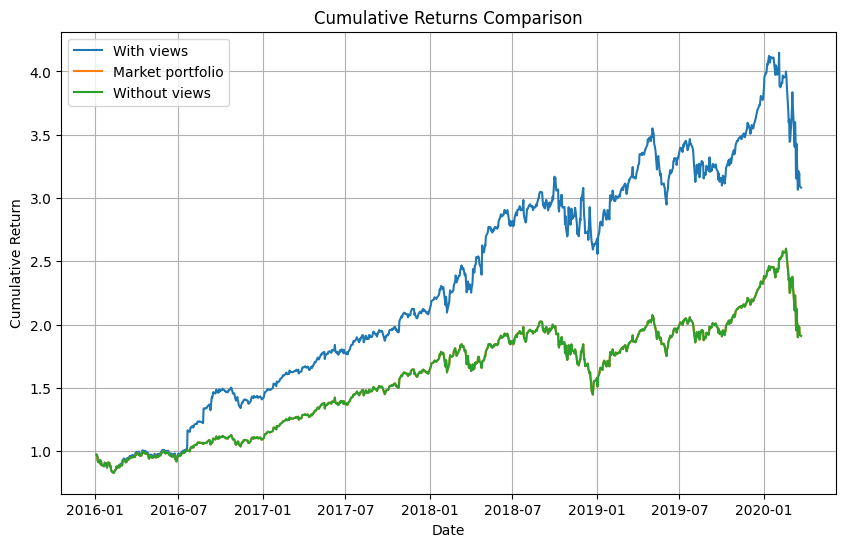

In [15]:
# Graph of the cumulative returns to get an insight
plt.figure(figsize=(10, 6))
plt.plot(cum_ret_BL, label='With views')
plt.plot(cum_ret_VW,label='Market portfolio')
plt.plot(cum_ret_NV, label='Without views')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


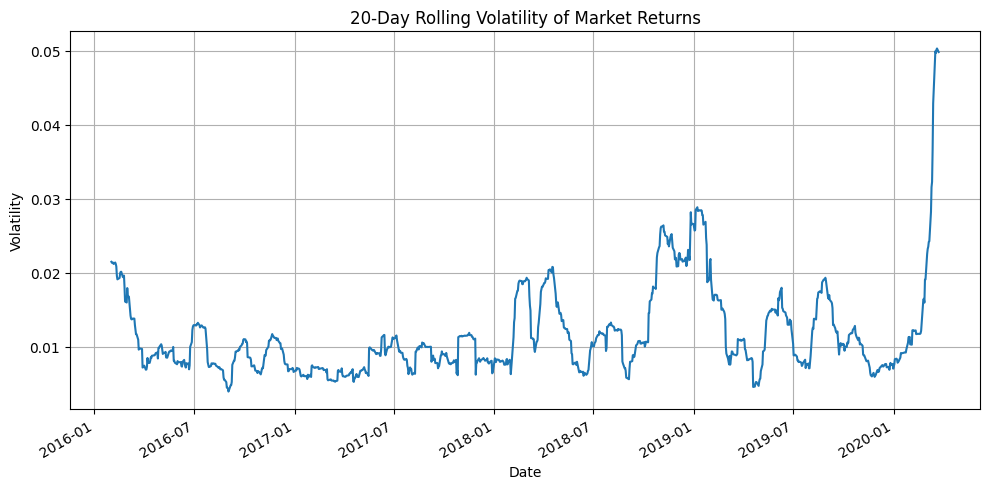

In [16]:
# Assuming `market_returns` is your daily return Series for the market portfolio
rolling_vol = ptf_ret_VW.rolling(window=20).std()

plt.figure(figsize=(10, 5))
rolling_vol.plot(title="20-Day Rolling Volatility of Market Returns")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()


## Analysis

In [17]:
# Set up without quantile filtering 
Q_old = compute_views_old_3(mu_tilda,df_polarity,start_date,end_date,beta_df,t_value_df,win_size_VT,2,2)
opti_weight_BL_old = optimized_weights_full_views_time_period(Q_old,t_value_df,tau,list_vcv,mu_tilda,constraints,
                                                          x0_vw,risk_aversion_2,tickers,start_date,end_date,
                                                          res_var_df,win_size_VT,df_returns,target_volatility,turnover_penalty)


### Signal Effectiveness vs. t-stat Threshold Analysis

The idea here is to analyse the number of successful signals and the total of signals triggered when we apply a t-stat filtering.

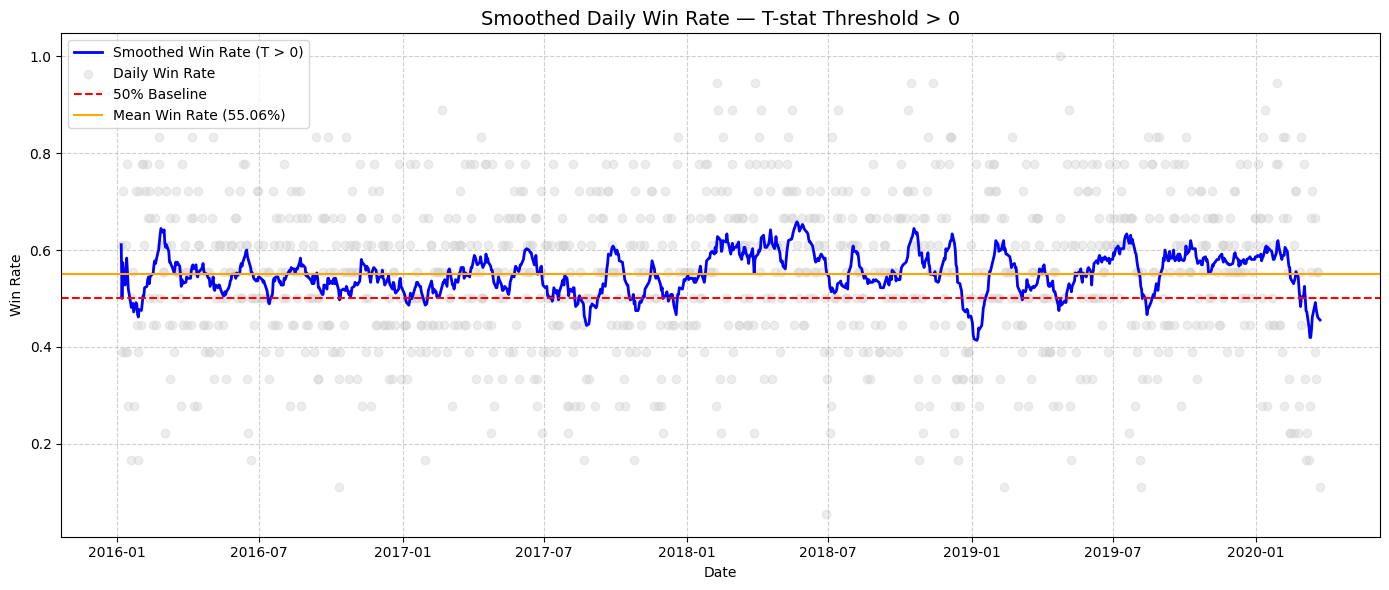

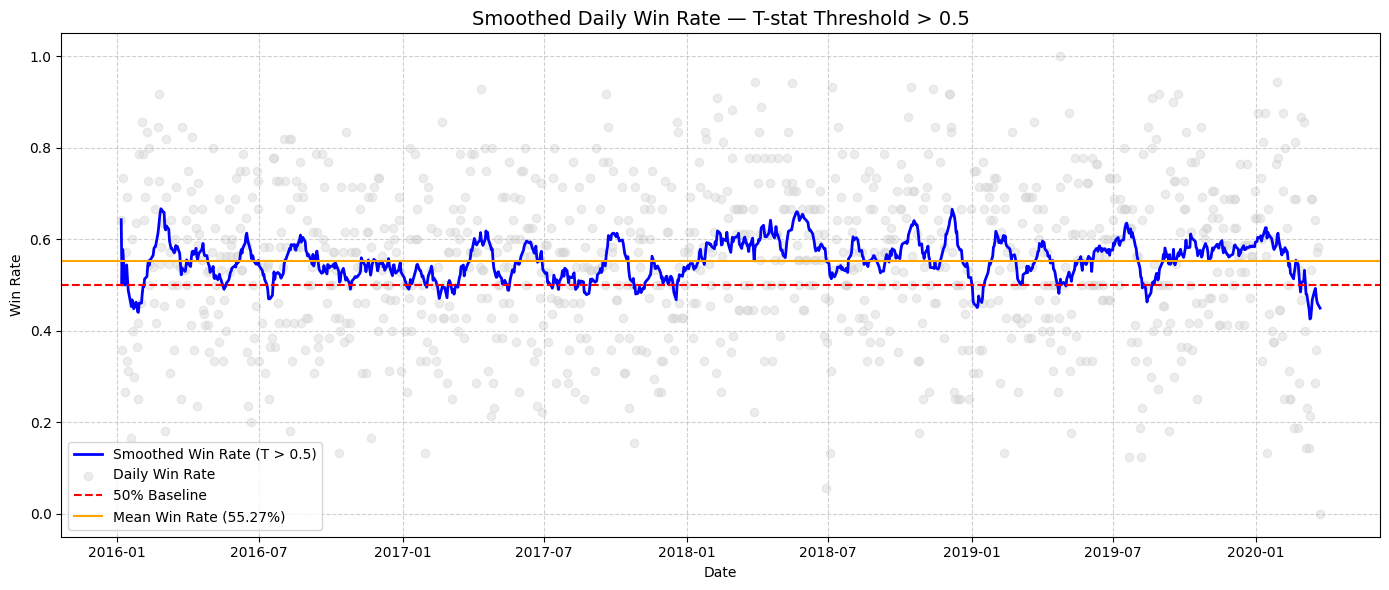

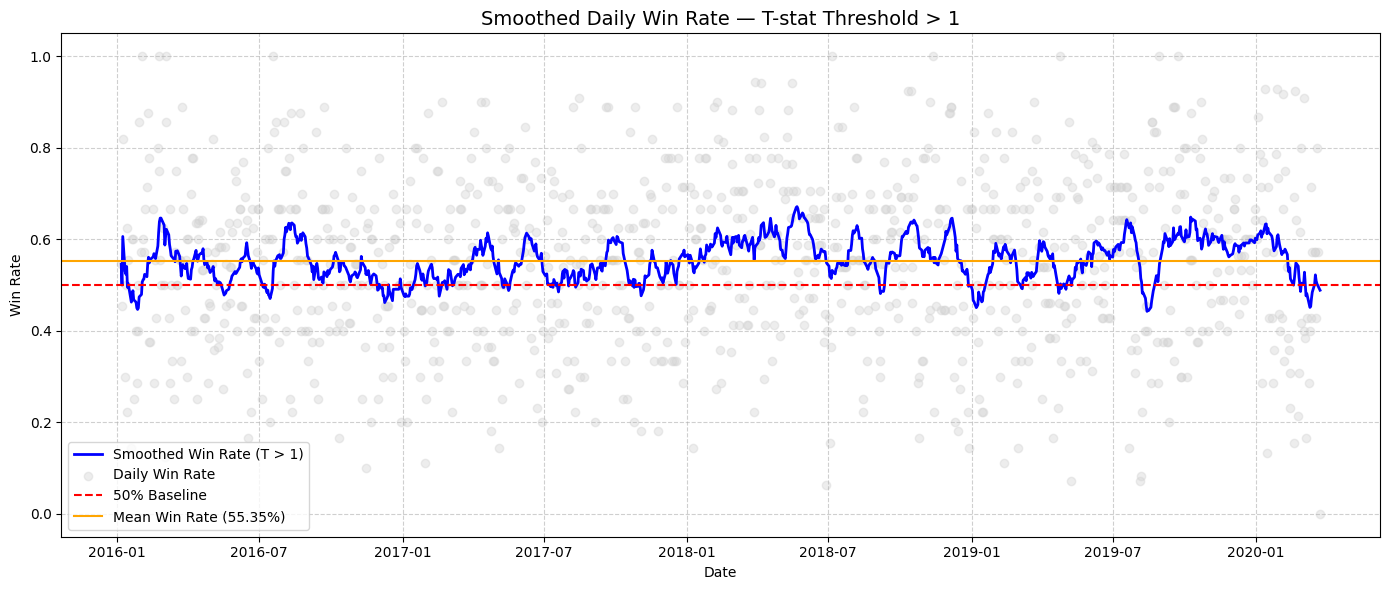

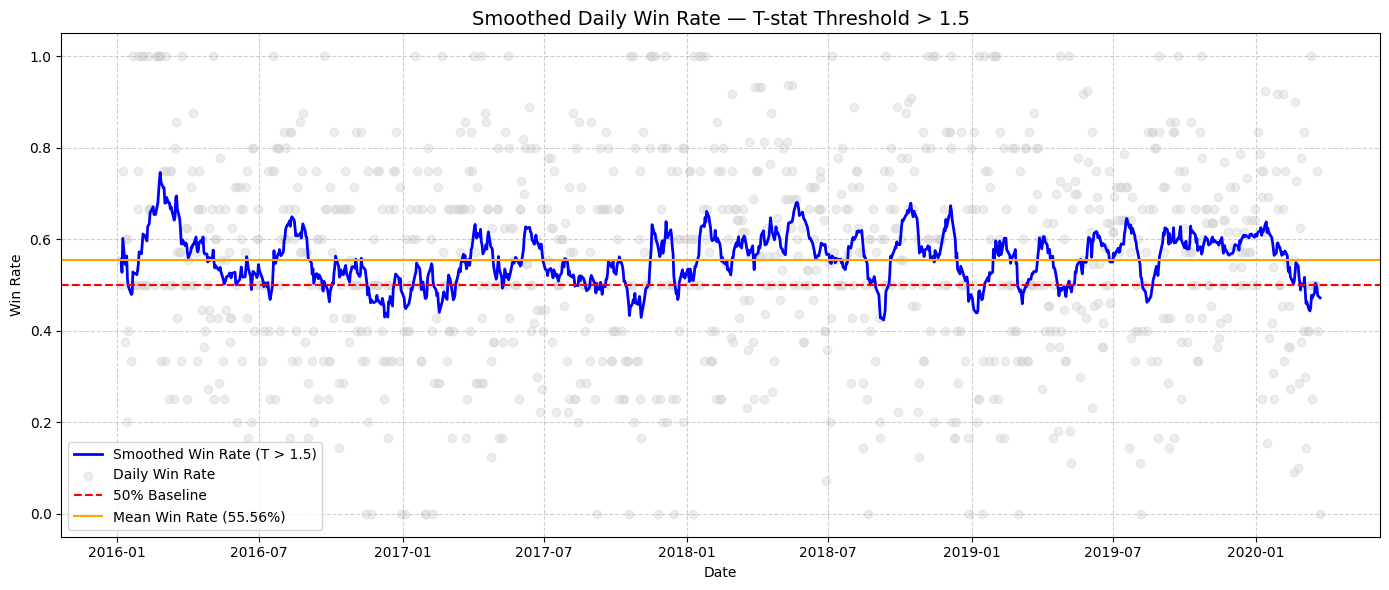

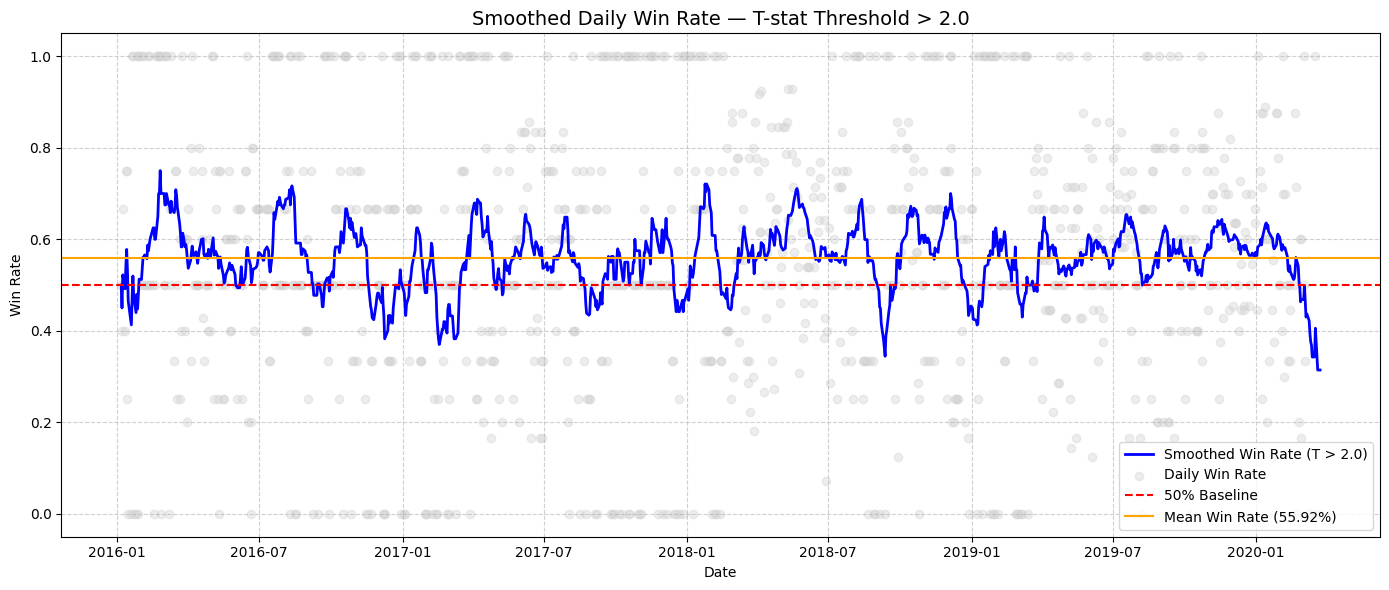

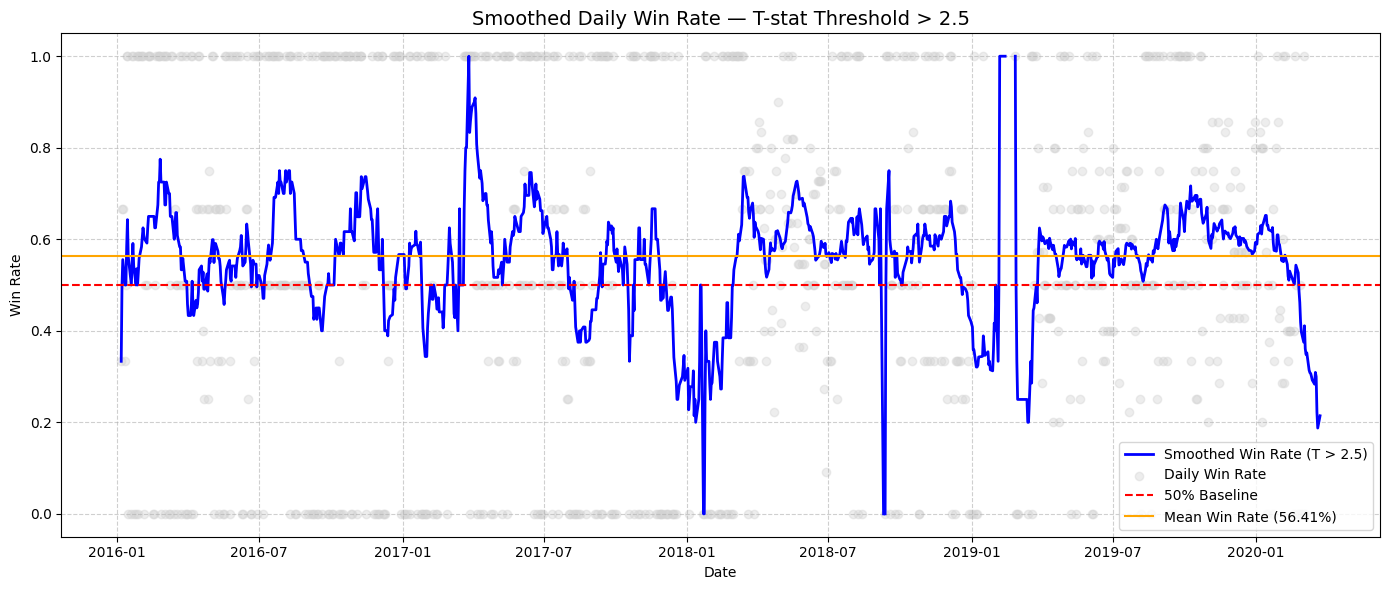

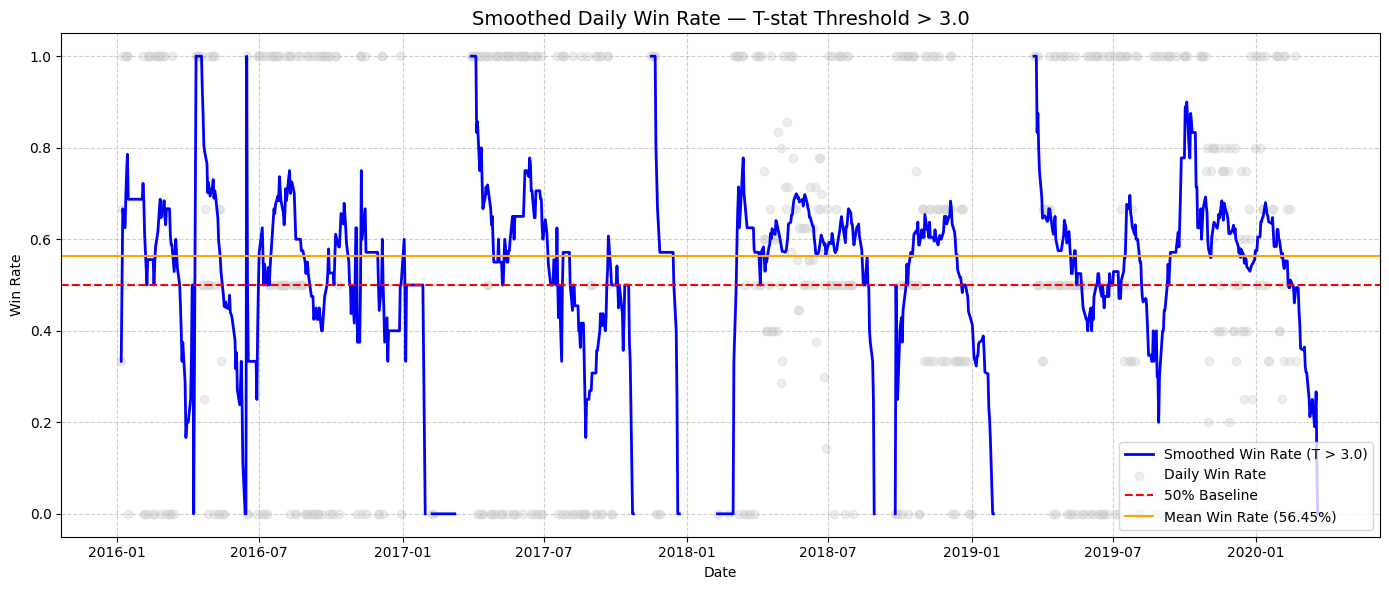

In [18]:
thresholds = [0,0.5,1,1.5, 2.0, 2.5, 3.0]
signal_analysis_by_threshold = {}

for threshold in thresholds:
    daily_signal_success = defaultdict(list)
    daily_signal_total = defaultdict(list)

    for ticker in tickers:
        df = pd.DataFrame({
            't_stat': t_value_df[ticker].loc[start_date:end_date],
            'prev_polarity_diff': df_polarity[ticker].loc[start_date:end_date].diff().shift(1),
            'return_diff': df_returns[ticker].loc[start_date:end_date].diff(),
            'return_prev': df_returns[ticker].loc[start_date:end_date].shift(1)
        }).dropna()


        # Filter by t-stat threshold
        signal_mask = df['t_stat'].abs() > threshold
        # Filter by t-stat and successful signals
        signal_works_mask = signal_mask & (np.sign(df['prev_polarity_diff']) != np.sign(df['return_diff']))
        # group by day
        per_day_success = signal_works_mask.groupby(df.index).sum()
        per_day_total = signal_mask.groupby(df.index).sum()
        
        for day in per_day_success.index:
            daily_signal_success[day].append(per_day_success[day])
            daily_signal_total[day].append(per_day_total[day])

    df_result = pd.DataFrame({
        'successful_signals': {day: sum(daily_signal_success[day]) for day in daily_signal_success},
        'total_signals': {day: sum(daily_signal_total[day]) for day in daily_signal_total},
    })
    
    # ✅ Add: Total number of signals triggered for this threshold
    total_signals = sum([sum(v) for v in daily_signal_total.values()])


    df_result['win_rate'] = df_result['successful_signals'] / df_result['total_signals']
    df_result['win_rate_smooth'] = df_result['win_rate'].rolling(window=20, min_periods=1).mean()

    signal_analysis_by_threshold[threshold] = {
    'df': df_result,
    'total_signals': total_signals
    }

    
    

        
for threshold, result in signal_analysis_by_threshold.items():
    df = result['df']
    total_signals = result['total_signals']

    plt.figure(figsize=(14, 6))
    
    plt.plot(df.index, df['win_rate_smooth'], label=f'Smoothed Win Rate (T > {threshold})', color='blue', linewidth=2)
    plt.scatter(df.index, df['win_rate'], color='lightgray', alpha=0.4, label='Daily Win Rate')
    
    plt.axhline(0.5, color='red', linestyle='--', linewidth=1.5, label='50% Baseline')
    mean_wr = df['win_rate'].mean()
    plt.axhline(mean_wr, color='orange', linestyle='-', linewidth=1.5, label=f'Mean Win Rate ({mean_wr * 100:.2f}%)')
    
    plt.title(f'Smoothed Daily Win Rate — T-stat Threshold > {threshold}', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Win Rate')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [19]:
summary_rows = []

for threshold, result in signal_analysis_by_threshold.items():
    df = result['df']
    total_signals = result['total_signals']
    mean_wr = df['win_rate'].mean()

    summary_rows.append({
        't_threshold': threshold,
        'total_signals': total_signals,
        'mean_win_rate (%)': round(mean_wr * 100, 2)
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by='t_threshold')
summary_df


,t_threshold,total_signals,mean_win_rate (%)
0,0.0,19026,55.06
1,0.5,15416,55.27
2,1.0,11778,55.35
3,1.5,8270,55.56
4,2.0,5293,55.92
5,2.5,2973,56.41
6,3.0,1532,56.45


Conclusion:
- The t-stat threshold improve slightly the winrate but not as much as I thought.
- Increase the t threshold drastically reduce the number of signals, especially at the beginning. Normal behaviour.
- What would be interesting next : compute the total return of the signals and compare between different t thresholds to find the good balance between total signals and winrate.
- For now I set t threshold = 2 for the following (arbitrary).





### Signal Effectiveness as a Function of Prior Return Quantile

In this case:
- Filter by fixed t-stat threshold (2)
- Filter by previous absolute return quantile. If the absolute previous return is above the quantile threshold we keep it.
- Check the win rate of the signals 

<Figure size 1400x600 with 0 Axes>

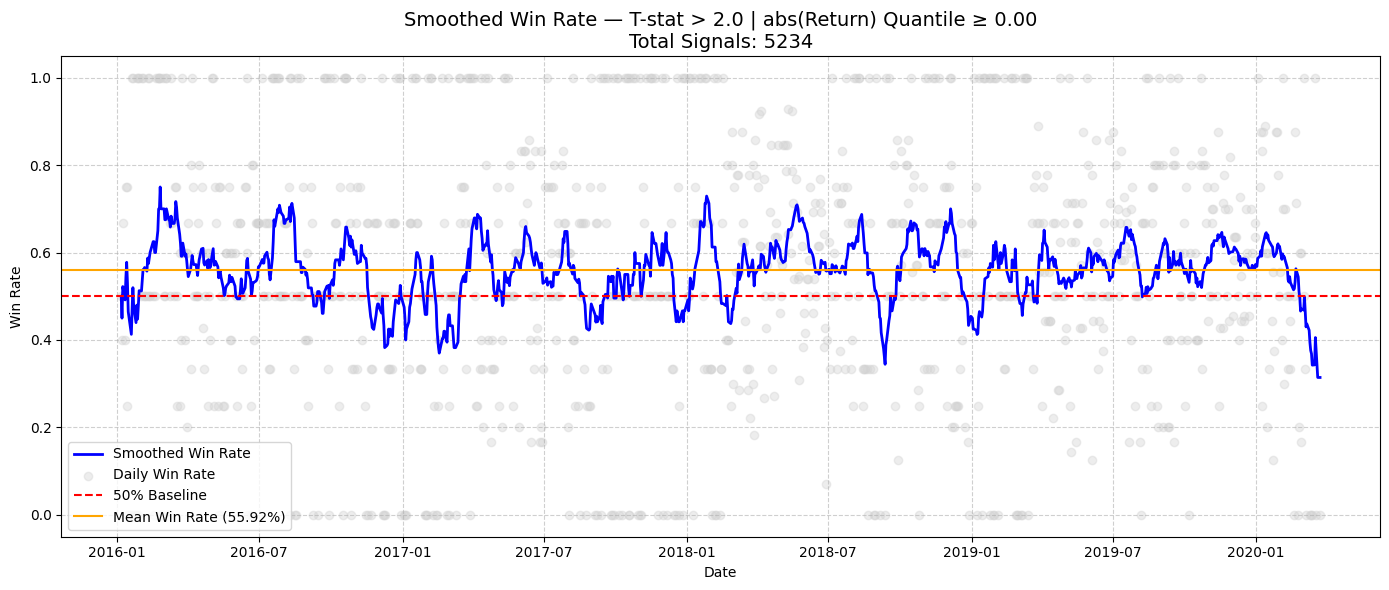

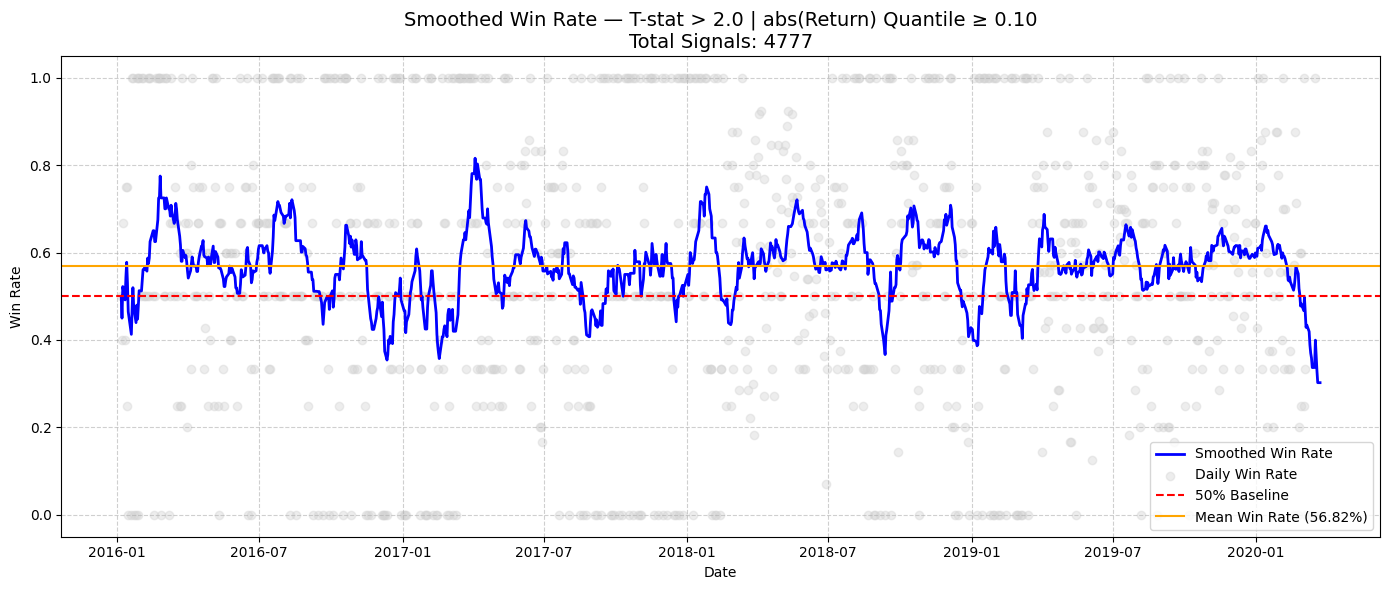

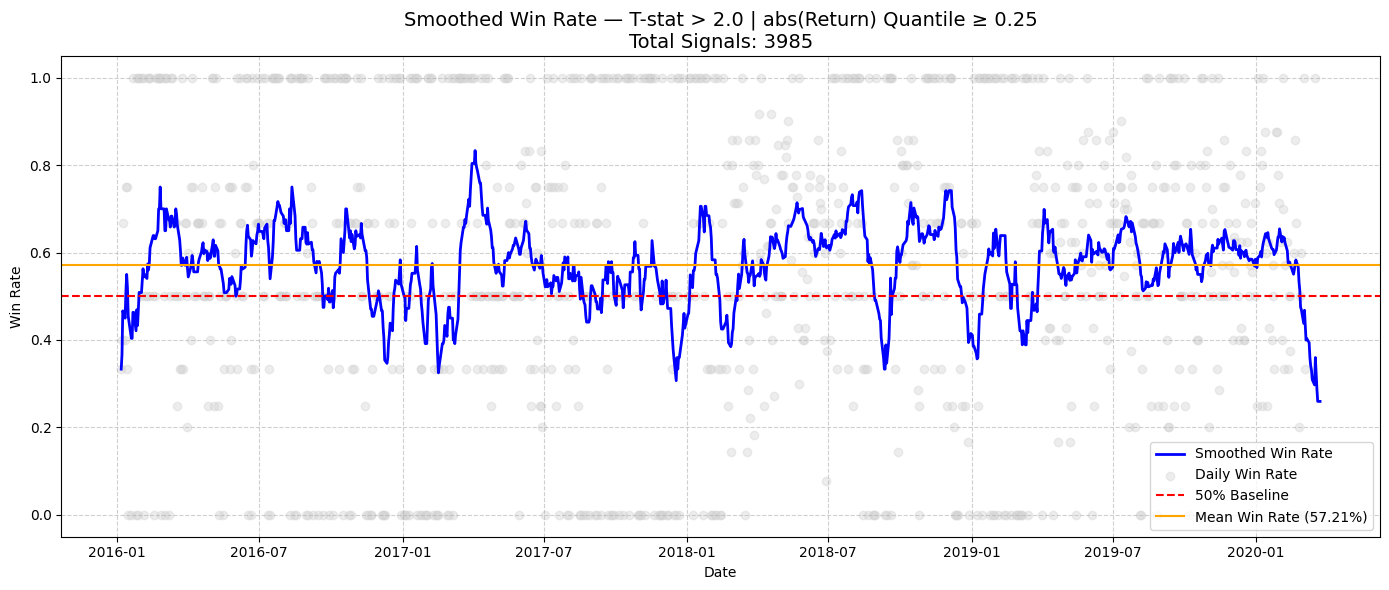

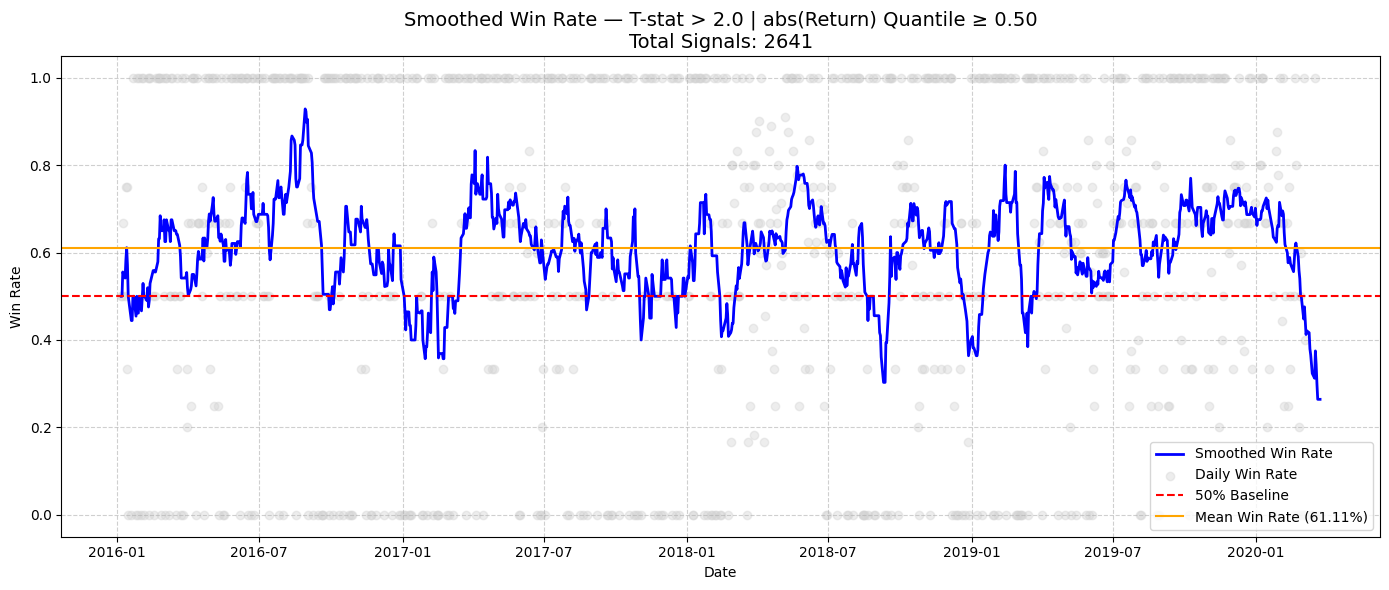

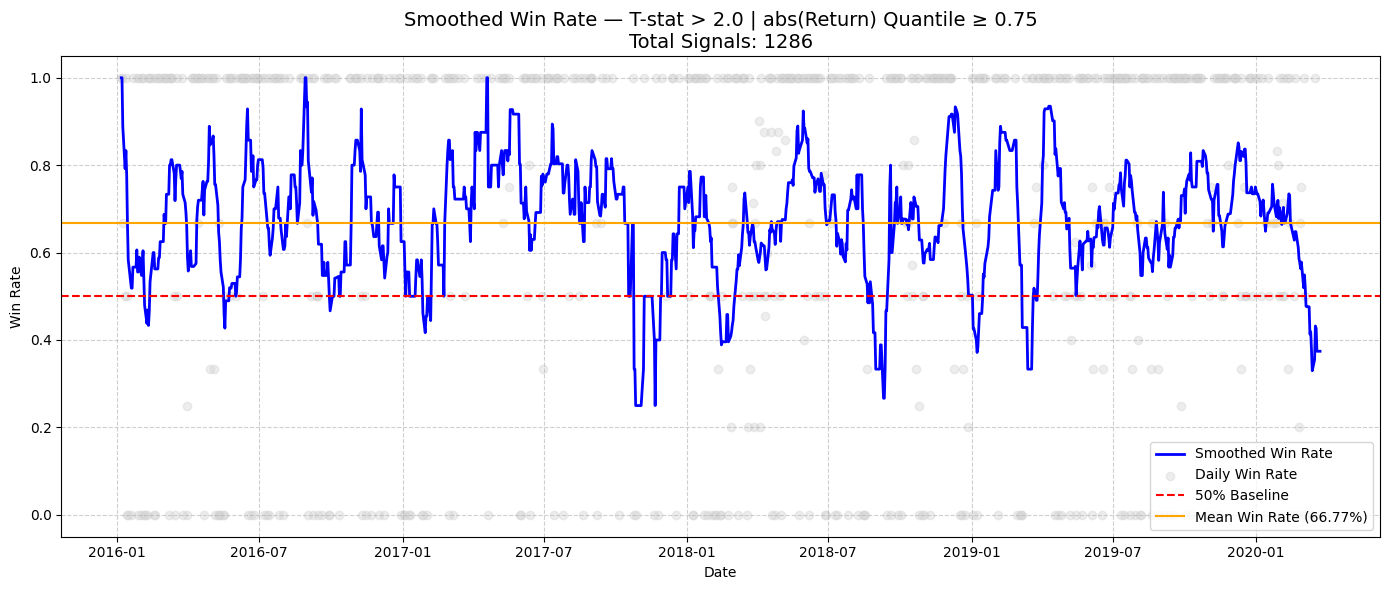

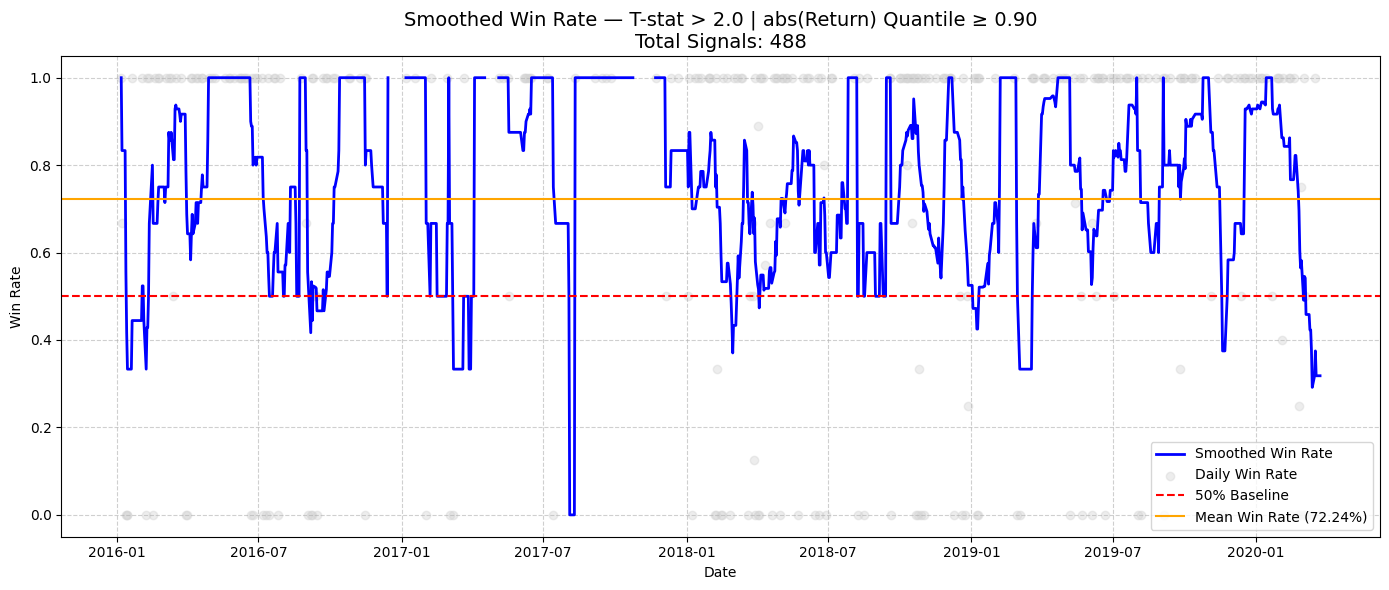

In [20]:
t_stat_threshold = 2.0
return_thresholds = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9]
signal_analysis_by_return_filter = {}

for q in return_thresholds:
    daily_signal_success = defaultdict(list)
    daily_signal_total = defaultdict(list)

    for ticker in tickers:
        df = pd.DataFrame({
            't_stat': t_value_df[ticker].loc[start_date:end_date],
            'prev_polarity_diff': df_polarity[ticker].loc[start_date:end_date].diff().shift(1),
            'return_diff': df_returns[ticker].loc[start_date:end_date].diff(),
            'return_prev': df_returns[ticker].loc[start_date:end_date].shift(1)
        }).dropna()

        # Compute absolute return threshold
        abs_ret_threshold = df['return_prev'].abs().quantile(q)

        # Apply both filters
        signal_mask = (df['t_stat'].abs() > t_stat_threshold) & (df['return_prev'].abs() > abs_ret_threshold)
        signal_works_mask = signal_mask & (np.sign(df['prev_polarity_diff']) != np.sign(df['return_diff']))

        # Aggregate daily signal counts
        per_day_success = signal_works_mask.groupby(df.index).sum()
        per_day_total = signal_mask.groupby(df.index).sum()

        for day in per_day_success.index:
            daily_signal_success[day].append(per_day_success[day])
            daily_signal_total[day].append(per_day_total[day])

    # Create daily win rate DataFrame
    df_result = pd.DataFrame({
        'successful_signals': {day: sum(daily_signal_success[day]) for day in daily_signal_success},
        'total_signals': {day: sum(daily_signal_total[day]) for day in daily_signal_total},
    })

    df_result['win_rate'] = df_result['successful_signals'] / df_result['total_signals']
    df_result['win_rate_smooth'] = df_result['win_rate'].rolling(window=20, min_periods=1).mean()
    total_signals = df_result['total_signals'].sum()

    signal_analysis_by_return_filter[q] = {
        'df': df_result,
        'total_signals': total_signals
    }

plt.figure(figsize=(14, 6))

for q, result in signal_analysis_by_return_filter.items():
    df = result['df']
    total_signals = result['total_signals']
    mean_wr = df['win_rate'].mean()

    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['win_rate_smooth'], color='blue', linewidth=2, label='Smoothed Win Rate')
    plt.scatter(df.index, df['win_rate'], color='lightgray', alpha=0.4, label='Daily Win Rate')
    plt.axhline(0.5, color='red', linestyle='--', linewidth=1.5, label='50% Baseline')
    plt.axhline(mean_wr, color='orange', linestyle='-', linewidth=1.5,
                label=f'Mean Win Rate ({mean_wr * 100:.2f}%)')

    plt.title(f'Smoothed Win Rate — T-stat > 2.0 | abs(Return) Quantile ≥ {q:.2f}\nTotal Signals: {total_signals}', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Win Rate')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [21]:
summary_rows = []

for q, result in signal_analysis_by_return_filter.items():
    df = result['df']
    summary_rows.append({
        'return_abs_quantile': q,
        'total_signals': result['total_signals'],
        'mean_win_rate (%)': round(df['win_rate'].mean() * 100, 2)
    })

summary_q_df = pd.DataFrame(summary_rows).sort_values(by='return_abs_quantile')
summary_q_df

,return_abs_quantile,total_signals,mean_win_rate (%)
0,0.00,5234,55.92
1,0.10,4777,56.82
2,0.25,3985,57.21
3,0.50,2641,61.11
4,0.75,1286,66.77
5,0.90,488,72.24


Conclusion:
- The signal is more effective during high volatile periods
- There is also a trade-off here between the number of signals and the winrate. A comparison of the total return for different quantile would be interesting.

### Quantile threshold VS market volatility

win rate of the strategy depending on the quantile threshold and the market volatility

In [22]:
rolling_vol = df_returns.mean(axis=1).rolling(window=20).std()
vol_thresholds = rolling_vol.quantile([0.33, 0.66])

def classify_vol(v):
    if v <= vol_thresholds[0.33]:
        return 'low'
    elif v <= vol_thresholds[0.66]:
        return 'medium'
    else:
        return 'high'

vol_regime = rolling_vol.apply(classify_vol)

return_thresholds = [0.0, 0.1, 0.25, 0.5, 0.75]
t_stat_threshold = 2.0
summary_rows = []

for q in return_thresholds:
    # Store per-regime counters
    regime_success = defaultdict(int)
    regime_total = defaultdict(int)

    for ticker in tickers:
        df = pd.DataFrame({
            't_stat': t_value_df[ticker].loc[start_date:end_date],
            'prev_polarity_diff': df_polarity[ticker].loc[start_date:end_date].diff().shift(1),
            'return_diff': df_returns[ticker].loc[start_date:end_date].diff(),
            'return_prev': df_returns[ticker].loc[start_date:end_date].shift(1)
        }).dropna()

        abs_ret_thresh = df['return_prev'].abs().quantile(q)

        signal_mask = (df['t_stat'].abs() > t_stat_threshold) & (df['return_prev'].abs() > abs_ret_thresh)
        signal_works_mask = signal_mask & (np.sign(df['prev_polarity_diff']) != np.sign(df['return_diff']))

        for day in signal_mask.index:
            if signal_mask.loc[day]:
                regime = vol_regime.get(day)
                regime_total[regime] += 1
                if signal_works_mask.loc[day]:
                    regime_success[regime] += 1

    # After all tickers, compute per-regime win rate
    for regime in ['low', 'medium', 'high']:
        total = regime_total[regime]
        success = regime_success[regime]
        win_rate = success / total * 100 if total > 0 else np.nan

        summary_rows.append({
            'Volatility Regime': regime,
            'Return Quantile': q,
            'Win Rate (%)': round(win_rate, 2),
            'Total Signals': total
        })
        
summary_final_df = pd.DataFrame(summary_rows)
summary_final_df = summary_final_df.sort_values(by=['Volatility Regime', 'Return Quantile'])
display(summary_final_df)

,Volatility Regime,Return Quantile,Win Rate (%),Total Signals
2,high,0.00,56.93,1386
5,high,0.10,57.53,1281
8,high,0.25,58.62,1102
11,high,0.50,59.37,822
14,high,0.75,62.39,460
0,low,0.00,56.30,2229
3,low,0.10,57.10,2014
6,low,0.25,59.45,1625
9,low,0.50,64.11,1003
12,low,0.75,68.68,431


In high volatility period, the win rate seems less affected by the quantile threshold than in the medium or low volatility.
Once again further analysis would be usefull to find an optimal trade off between quantity and quality. But since the win rate is less sensitive in high volatility , i have more incentive to reduce the quantile threshold to increase the number of signals.

## Compute metrics and returns for all portfolio variants

(Remove the apostrophes to run it)

In [27]:


# start_date = '2016-01-04'
# end_date = '2020-03-23'
# tau=0.05
# window_size = [60,90,120]
# risk_aversion_1 =2
# risk_aversion_2 = [1,2,3,4,5]
# turnover_penalty = np.arange(0.0010,0.0026,0.0001)
# trans_cost = [0,0.0010, 0.0025, 0.0050]  # 10bps, 25bps, 50bps
# win_size_VT = 20
# target_volatility = [0.10,0.15,0.20,0.25,np.inf]
# constraints = [LinearConstraint(np.ones(tickers.shape[0]), ub = 1),
#             LinearConstraint(-np.ones(tickers.shape[0]), ub = -1),
#             LinearConstraint(np.eye(tickers.shape[0]), lb = 0)]

# # Set lists to store
# metric_list_BL = []
# cum_ret_list_BL = []
# drawdown_list_BL = []
# metric_list_BL_NV = []
# cum_ret_list_BL_NV = []
# drawdown_list_BL_NV = []
# metric_list_VW = []
# cum_ret_list_VW = []
# drawdown_list_VW = []

# # Iteration over all parameters possibilities
# for tv in target_volatility:
#     opti_weight_VW = weights_ptf_VW(x0_vw,df_returns,start_date,end_date,win_size_VT,tv)
#     for tc in trans_cost:
#         param_label = f'tc={tc}_tv={tv}'
#         ptf_ret_VW = ptf_daily_return(df_returns,opti_weight_VW,tc,start_date,end_date,rf_data)
#         cum_ret_VW = cumulative_return(ptf_ret_VW,start_date,end_date)
#         cum_ret_list_VW.append((param_label,cum_ret_VW))
#         metric_list_VW.append(ptf_metrics(ptf_ret_VW,rf_data,cum_ret_VW,start_date,end_date,param_label))
#         drawdown_list_VW.append((param_label,drawdown_over_time(cum_ret_VW,start_date,end_date)))
# for window in window_size:
#     list_vcv = variance_covariance_matrix(start_date,end_date, df_returns, window,win_size_VT)
#     beta_df,t_value_df,res_var_df = reg_var_pol_var_ret_all_tickers(df_polarity,df_returns,start_date,end_date,window,tickers,win_size_VT)
#     mu_tilda = calculate_implied_exp_returns_for_a_time_period(list_vcv,x0_vw,rf_data,risk_aversion_1,start_date,end_date,win_size_VT)
#     compute_views(mu_tilda,df_polarity,start_date,end_date,beta_df,t_value_df,win_size_VT,2,2,df_returns,60)
#     for risk in risk_aversion_2:
#         for tv in target_volatility:
#             for tp in turnover_penalty:
#                 opti_weight_BL_NV = weights_ptf_no_views(constraints,start_date,end_date,list_vcv,risk,mu_tilda,x0_vw,df_returns,win_size_VT,tv,tp)
#                 opti_weight_BL = optimized_weights_full_views_time_period(Q,t_value_df,tau,list_vcv,mu_tilda,constraints,
#                                                         x0_vw,risk,tickers,start_date,end_date,
#                                                         res_var_df,win_size_VT,df_returns,tv,tp)               
#                 for tc in trans_cost:

#                     param_label = f'win={window}_risk={risk}_tc={tc}_tv={tv}_tp={tp}'
#                     ptf_ret_BL_NV = ptf_daily_return(df_returns,opti_weight_BL_NV,tc,start_date,end_date,rf_data)
#                     cum_ret_BL_NV = cumulative_return(ptf_ret_BL_NV,start_date,end_date)
#                     cum_ret_list_BL_NV.append((param_label,cum_ret_BL_NV))
#                     metric_list_BL_NV.append(ptf_metrics(ptf_ret_BL_NV,rf_data,cum_ret_BL_NV,start_date,end_date,param_label))
#                     drawdown_list_BL_NV.append((param_label,drawdown_over_time(cum_ret_BL_NV,start_date,end_date)))

                    
#                     ptf_ret_BL = ptf_daily_return(df_returns,opti_weight_BL,tc,start_date,end_date,rf_data)
#                     cum_ret_BL = cumulative_return(ptf_ret_BL,start_date,end_date)
#                     cum_ret_list_BL.append((param_label,cum_ret_BL))
#                     metric_list_BL.append(ptf_metrics(ptf_ret_BL,rf_data,cum_ret_BL,start_date,end_date,param_label))
#                     drawdown_list_BL.append((param_label,drawdown_over_time(cum_ret_BL,start_date,end_date)))

# # Group results                  
# metric_df_BL = pd.concat(metric_list_BL, axis=1)
# cum_ret_df_BL = pd.concat([s.rename(label) for label, s in cum_ret_list_BL], axis=1)
# drawdown_df_BL = pd.concat([s.rename(label) for label, s in drawdown_list_BL], axis=1)

# metric_df_NV = pd.concat(metric_list_BL_NV, axis=1)
# cum_ret_df_NV = pd.concat([s.rename(label) for label, s in cum_ret_list_BL_NV], axis=1)
# drawdown_df_NV = pd.concat([s.rename(label) for label, s in drawdown_list_BL_NV], axis=1)

# metric_df_VW = pd.concat(metric_list_VW, axis=1)
# cum_ret_df_VW = pd.concat([s.rename(label) for label, s in cum_ret_list_VW], axis=1)
# drawdown_df_VW = pd.concat([s.rename(label) for label, s in drawdown_list_VW], axis=1)

# #Save data
# path = r'C:\Users\remyd\Desktop\HEC\Master II\QARM\Project\data_streamlit\\'
# metric_df_BL.to_csv(path+'metric_df_BL.csv')
# cum_ret_df_BL.to_csv(path+'cum_ret_df_BL.csv')
# drawdown_df_BL.to_csv(path+'drawdown_df_BL.csv')

# metric_df_NV.to_csv(path+'metric_df_NV.csv')
# cum_ret_df_NV.to_csv(path+'cum_ret_df_NV.csv')
# drawdown_df_NV.to_csv(path+'drawdown_df_NV.csv')

# metric_df_VW.to_csv(path+'metric_df_VW.csv')
# cum_ret_df_VW.to_csv(path+'cum_ret_df_VW.csv')
# drawdown_df_VW.to_csv(path+'drawdown_df_VW.csv')
